# IMPORT MODULES

In [1366]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import scipy.stats
import statistics
import math

## Import, Clean, and Examine Data
## (only needs to run when fresh data input)

In [1367]:
data= pd.read_csv('./challenge.csv')

In [1368]:
##examine headers
data.head()

year  gameid  tm_home  tm_score  opp_score  month  day  tm_ot  opp_ot  \
0  2007    2875        1        13         14      8   30    NaN     NaN   
1  2007    2875        0        14         13      8   30    NaN     NaN   
2  2007    2878        1        14         23      8   30    NaN     NaN   
3  2007    2878        0        23         14      8   30    NaN     NaN   
4  2007    2879        0        35         17      8   30    NaN     NaN   

   line_p  ...  tot_p_omon_h1  tot_p_umon_h1  tm_h1  tm_h2  opp_h1  opp_h2  \
0    -4.0  ...         -114.0          104.0    3.0   10.0     7.0     7.0   
1     4.0  ...         -114.0          104.0    7.0    7.0     3.0    10.0   
2    -3.5  ...            NaN            NaN    7.0    7.0     9.0    14.0   
3     3.5  ...            NaN            NaN    9.0   14.0     7.0     7.0   
4    -3.5  ...            NaN            NaN   14.0   21.0    17.0     0.0   

   season  week  tmid  oppid  
0    2007     1    17    107  
1    2007     1   107     17  
2    2007     1    82     88  
3    2007     1    88     82  
4    2007     1   202     97  

[5 rows x 27 columns]

In [1369]:
##Create columns for first half score as a difference and as a total instead of tm and opp.
data['diff_h1']=data['opp_h1']-data['tm_h1']
data['tot_h1']=data['opp_h1']+data['tm_h1']

##reduce number of columns to just information required
data_simp = data.drop(columns=['tm_home','tm_score','opp_score','month','day','tm_ot','opp_ot','tmid','oppid','year','tm_h2','opp_h2','tm_h1','opp_h1'])

##check how many lines have no NANs for each column
print(data_simp.count())


gameid           20420
line_p           20420
line_p_mon       20420
tot_p            19053
tot_p_omon       19055
tot_p_umon       19054
line_p_h1        18702
line_p_mon_h1    18702
tot_p_h1         18557
tot_p_omon_h1    18557
tot_p_umon_h1    18558
season           20420
week             20420
diff_h1          18464
tot_h1           18464
dtype: int64


In [1370]:
##appears to be enough rows without NaN's for the model so just use rows with full data for simplicity
data_clean = data_simp.dropna()

##check results dataframe shape is as expected
print(data_clean.count())

gameid           16912
line_p           16912
line_p_mon       16912
tot_p            16912
tot_p_omon       16912
tot_p_umon       16912
line_p_h1        16912
line_p_mon_h1    16912
tot_p_h1         16912
tot_p_omon_h1    16912
tot_p_umon_h1    16912
season           16912
week             16912
diff_h1          16912
tot_h1           16912
dtype: int64


In [1371]:
##Examine data to check for outliers that could be errors, and as a basis for future assumptions/simplifications.

## show how many in each year for train/test data dividing purposes. 
print(data_clean[['season','gameid']].groupby('season').count())

##include median and +/- 1,2,3 standard deviatons
data_clean.describe(percentiles=[.0015,.02,.16,.5,.84,.98,.9985])


        gameid
season        
2007      1238
2008       628
2009      1294
2010      1290
2011      1422
2012      1420
2013      1438
2014      1470
2015      1508
2016      1508
2017      1362
2018      1518
2020       816


gameid        line_p    line_p_mon         tot_p    tot_p_omon  \
count  16912.000000  16912.000000  16912.000000  16912.000000  16912.000000   
mean    8450.176325     -0.002129    -74.814037     55.440397    -86.305582   
std     3032.334726     14.540965     75.703845      8.057865     62.352810   
min     2875.000000    -54.500000   -147.000000     34.000000   -154.000000   
0.2%    2896.366500    -44.000000   -126.000000     37.000000   -127.000000   
2%      3127.000000    -31.000000   -117.000000     41.000000   -116.000000   
16%     5018.520000    -14.000000   -110.000000     47.500000   -110.000000   
50%     8441.500000      0.000000   -106.000000     54.500000   -106.000000   
84%    11867.240000     14.000000   -100.000000     63.500000   -102.000000   
98%    14088.000000     31.000000    105.000000     74.000000    103.000000   
99.9%  14249.633500     44.000000    113.000000     83.816750    111.000000   
max    14262.000000     54.500000    124.000000     90.000000    117.000000   

         tot_p_umon     line_p_h1  line_p_mon_h1      tot_p_h1  tot_p_omon_h1  \
count  16912.000000  16912.000000   16912.000000  16912.000000    16912.00000   
mean     -85.735691     -0.001478     -51.460620     28.211566      -48.78329   
std       62.968511      8.501310      95.463757      4.342940       96.96284   
min     -133.000000    -35.500000    -160.000000     16.500000     -165.00000   
0.2%    -125.000000    -27.316750    -135.633500     18.500000     -138.00000   
2%      -116.000000    -18.000000    -125.000000     20.500000     -126.00000   
16%     -110.000000     -7.500000    -114.000000     24.000000     -114.00000   
50%     -106.000000      0.000000    -106.000000     27.750000     -106.00000   
84%     -102.000000      7.500000     102.000000     33.000000      102.00000   
98%      104.000000     18.000000     111.000000     38.000000      113.00000   
99.9%    112.000000     27.316750     121.000000     44.000000      125.63350   
max      139.000000     35.500000     142.000000     46.000000      147.00000   

       tot_p_umon_h1        season          week       diff_h1        tot_h1  
count   16912.000000  16912.000000  16912.000000  16912.000000  16912.000000  
mean      -60.303867   2013.229541      8.186258     -0.000414     28.876242  
std        90.936593      3.603549      4.093587     14.901849     12.198402  
min      -162.000000   2007.000000      1.000000    -59.000000      0.000000  
0.2%     -142.000000   2007.000000      1.000000    -45.000000      0.000000  
2%       -127.000000   2007.000000      1.000000    -31.000000      7.000000  
16%      -115.000000   2009.000000      3.000000    -14.000000     17.000000  
50%      -106.000000   2013.000000      8.000000      0.000000     28.000000  
84%       101.000000   2017.000000     13.000000     14.000000     41.000000  
98%       111.000000   2020.000000     16.000000     31.000000     56.000000  
99.9%     122.000000   2020.000000     17.000000     45.000000     72.633500  
max       146.000000   2020.000000     17.000000     59.000000     94.000000

In [1372]:
##Since we're assuming just the full game spread/total as efficient, need to make my own simple 1h spread/total model
##SIMPLIFICATION 
    ## Data desciption table above shows almost all spread/total moneylines have roughly 50/50 implied probably. 
    ## To simplify first pass model, I'm going to assume the full game spread/total listed ARE the median 50/50 point...
    ## and not adjust for exact ML value for 1H predictor model.

##SIMPLIFICATON - Remove Entries with Full game spread between 2.5 and -2.5 since aren't likely to corroleate to total
data_clean_no2p5=data_clean[data_clean.line_p<-2.5].append(data_clean[data_clean.line_p>2.5])

##Seperate into train and test by year. 
##Train on 2007 to 2015, test 2016-2018.  REMOVE 2020 data because it's an odd covid year. about 25/75 train test split 
##2019 was already removed during NaN filtering because it had no H1 data. 
##SIMPLIFICATION - should weigh recent years more if we were really trying to predict an upcoming season, but won't here for simplificity
data_test = data_clean_no2p5[data_clean_no2p5.season>=2016][data_clean_no2p5.season!=2020]
data_train = data_clean_no2p5[data_clean_no2p5.season<=2015]

## check split
print(data_test[['season','gameid']].groupby('season').count())
print(data_test.shape)
print(data_train[['season','gameid']].groupby('season').count())
print(data_train.shape)

        gameid
season        
2016      1354
2017      1208
2018      1332
(3894, 15)
        gameid
season        
2007      1100
2008       522
2009      1154
2010      1138
2011      1252
2012      1224
2013      1300
2014      1294
2015      1326
(10310, 15)


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## Developing Linear Regression for 1H lines based on full game lines
## (only needs to run when fresh data input)


In [1373]:
#linear regression to predict 1h diff and total using closing full game lines. still assumes these are all the 50/50 spreads/totals.
# SIMPLIFICATION - in reality would need to adjust the predicted 1h lines so they make sense relative to key numbers (-3, 49 etc)

 
X_diff=data_train[['line_p']]
X_tot=data_train[['tot_p']]
y_diff_h1=data_train[['diff_h1']]
y_tot_h1=data_train[['tot_h1']]
reg_diff_h1 = LinearRegression().fit(X_diff, y_diff_h1)
reg_tot_h1 = LinearRegression().fit(X_tot, y_tot_h1)

#compare predictions of 1H lines against results and against the real closing line (should be very close to closing lines)
X_test_diff=data_test[['line_p']]
X_test_tot=data_test[['tot_p']]
y_test_diff_results=data_test[['diff_h1']]
y_test_diff_line=data_test[['line_p_h1']]
y_test_tot_results=data_test[['tot_h1']]
y_test_tot_line=data_test[['tot_p_h1']]

y_pred_diff = reg_diff_h1.predict(X_test_diff)
y_pred_tot = reg_tot_h1.predict(X_test_tot)

print(' Coefficients diff: \n', reg_diff_h1.coef_)
# RMSE is standard deviation of the results of the predictor. Used later for making distrobution 
print('\n RMS Error for Predicted Difference vs RESULTS: %.2f'
      % mean_squared_error(y_test_diff_results, y_pred_diff, squared=False))

# The coefficient of determination: 1 is perfect prediction
print(' R^2 Predicted Difference vs Results: %.2f'
      % r2_score(y_test_diff_results, y_pred_diff))
print('\n Root Mean squared error Predicted Difference vs Closing Line: %.2f'
      % mean_squared_error(y_test_diff_line, y_pred_diff,squared=False))
print(' R^2 Predicted Difference vs Closing Line: %.2f'
      % r2_score(y_test_diff_line, y_pred_diff))
print('\n How good of a predictor is the closing 1H line for comparison?')
print('   RMS Error for Closing 1H Spread vs 1H results: %.2f'
      % mean_squared_error(y_test_diff_line, y_test_diff_results,squared=False))
print('   R^2 for Closing 1H Spread vs 1H results: %.2f'
      % r2_score(data_test[['diff_h1']], data_test[['line_p_h1']]))

print('\n Coefficients tot: \n', reg_tot_h1.coef_)
print('\n RMS Error Predicted Total vs RESULTS: %.2f'
      % mean_squared_error(y_test_tot_results, y_pred_tot,squared=False))

print(' R^2 Predicted Total vs RESULTS: %.2f'
      % r2_score(y_test_tot_results, y_pred_tot))
print('\n RMS Error for Predicted Total versus Closing Line: %.2f'
      % mean_squared_error(y_test_tot_line,y_pred_tot,squared=False))
print(' R^2 for Predicted Total versus Closing Line: %.2f'
      % r2_score(y_test_tot_line, y_pred_tot))
print('\n How good of a predictor is the closing 1H line for comparison?')
print('   RMS Error for Closing 1H Total vs 1H Results: %.2f'
      % mean_squared_error(y_test_tot_line, y_test_tot_results,squared=False))
print('   R^2 for Closing 1H Total vs 1H Results: %.2f'
      % r2_score(data_test[['tot_h1']], data_test[['tot_p_h1']]))




 Coefficients diff: 
 [[0.6074788]]

 RMS Error for Predicted Difference vs RESULTS: 12.25
 R^2 Predicted Difference vs Results: 0.38

 Root Mean squared error Predicted Difference vs Closing Line: 0.70
 R^2 Predicted Difference vs Closing Line: 0.99

 How good of a predictor is the closing 1H line for comparison?
   RMS Error for Closing 1H Spread vs 1H results: 12.26
   R^2 for Closing 1H Spread vs 1H results: 0.38

 Coefficients tot: 
 [[0.55197777]]

 RMS Error Predicted Total vs RESULTS: 11.43
 R^2 Predicted Total vs RESULTS: 0.15

 RMS Error for Predicted Total versus Closing Line: 1.25
 R^2 for Predicted Total versus Closing Line: 0.93

 How good of a predictor is the closing 1H line for comparison?
   RMS Error for Closing 1H Total vs 1H Results: 11.43
   R^2 for Closing 1H Total vs 1H Results: 0.15


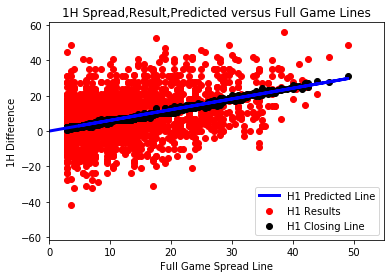

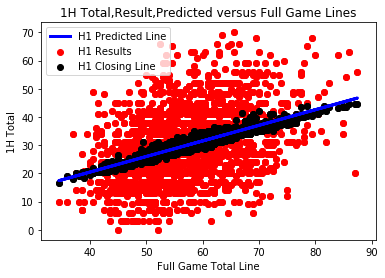

In [1374]:
# Tried using both line and total as inputs for both but it made zero difference to accuracy.
# Single variable linear regression of full game lines is very basic but appears to match 1H closing lines.

plt.scatter(data_test[['line_p']], y_test_diff_results,  color='red')
plt.scatter(data_test[['line_p']], y_test_diff_line,  color='black')
plt.plot(data_test[['line_p']], y_pred_diff, color='blue', linewidth=3)
plt.title('1H Spread,Result,Predicted versus Full Game Lines')
plt.xlabel('Full Game Spread Line')
plt.ylabel('1H Difference')

# set x limit to 0. otherwise you'd see a mirror image for the negative spreads for the opponents
plt.xlim(0)
plt.legend(['H1 Predicted Line','H1 Results','H1 Closing Line'])
plt.show()

plt.scatter(data_test[['tot_p']], y_test_tot_results,  color='red')
plt.scatter(data_test[['tot_p']], y_test_tot_line,  color='black')
plt.plot(data_test[['tot_p']], y_pred_tot, color='blue', linewidth=3)
plt.title('1H Total,Result,Predicted versus Full Game Lines')
plt.xlabel('Full Game Total Line')
plt.ylabel('1H Total')
plt.legend(['H1 Predicted Line','H1 Results','H1 Closing Line'])
plt.show()

### 1H ODDS FUNCTION - Part of Parlay Pricer

In [1375]:
## Create sub-function 
    ## input: full game spread/total and a desired 1H spread/total to be parlayed
    ## output: win/push probability for fav & over or dog & under depending on whether input is a fav or dog

## use train dataset to establish standard deviations for H1 spreads and total results
## note: square=false to get the ROOT MSE which is the standard deviation of the error from the predicted (mean) value.
sd_tot = mean_squared_error(data_train[['tot_h1']], data_train[['tot_p_h1']], squared=False)
sd_diff = mean_squared_error(data_train[['diff_h1']], data_train[['line_p_h1']], squared=False)
  
def odds (spread,total,H1_spread,H1_total):

    #establish mean H1 predictions using lin reg from before
    H1_spread_mean=reg_diff_h1.predict([[spread]])
    H1_total_mean=reg_tot_h1.predict([[total]])
    
    #SIMPLIFICATION - assume that alternate 1H spreads/totals are priced by making a normal distribution centered...
        # around a mean of the predicted 1H spread/total with a standard deviate = root mean squared error of the lin reg.
        # Likely that standard deviation changes depending on size of spread/total, but assuming constant for now.
        # Use normal distribution function to determine probablility of covering.
        # Again, not incorporating adjustments for "key numbers"
    
 
    #for favorites/over
    if H1_spread < 0:
        
        # check for push on spread- function defined above
        if (H1_spread)==int(H1_spread):
            
            #estimate of push probablility: for example for a spread of 3, find the cuml probability associated with 2.5 to 3.5 
            prob_push_spread=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread+0.5)-scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread-0.5)
            
            # a favorite covering would a more negative number so it's equal to the cdf as opposed to 1-cdf (cuml density)
            # since there's a chance of a push, would need do probablility up until 2.5 if the spread is 3 
            prob_fav=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread-.5)
         
        else:
            
            prob_push_spread = 0
            # don't have to alter by 0.5 since no push probability
            prob_fav=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread)
            
        # check for push on total
        if (H1_total)==int(H1_total):
        
            prob_push_total=scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total+0.5)-scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total-0.5)
            prob_over=1-scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total+0.5)
        
        else: 
           
            prob_push_total=0
            prob_over=1-scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total)
        
        
        #decimal odds
        dec_fav = (1-prob_push_spread)/prob_fav
        dec_over = (1-prob_push_total)/prob_over
        
        
        print('\n\n Model Decimal Odds to bet Fav: \n%.2f' % dec_fav)
        print('\n Probability Fav covers: \n%.3f' % prob_fav)
        print(' Probability Spread Pushes: \n%.3f' % prob_push_spread)

        print('\n Model Decimal Odds to bet Over: \n%.2f' % dec_over)
        print('\n Probability Over covers: \n%.3f' % prob_over)
        print(' Probability Total Pushes: \n%.3f' % prob_push_total)

        
        return (prob_fav,prob_push_spread,dec_fav,prob_over,prob_push_total,dec_over) 
    
    #same for dogs/under
    else: 
        
        if (H1_spread)==int(H1_spread):
            
            prob_push_spread=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread+0.5)-scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread-0.5)
            prob_dog=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread-0.5)

        else:
            
            prob_push_spread = 0
            prob_dog=scipy.stats.norm(H1_spread_mean, sd_diff).cdf(H1_spread)
    
        if (H1_total)==int(H1_total):
        
            prob_push_total=scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total+0.5)-scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total-0.5)
            prob_under=scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total-0.5)
            
        else:
                
            prob_push_total = 0
            prob_under=scipy.stats.norm(H1_total_mean, sd_tot).cdf(H1_total)
    
        dec_dog= (1-prob_push_spread)/prob_dog
        dec_under = (1-prob_push_total)/prob_under
        
        print(' Model Decimal Odds to bet Dog: \n %.2f' % dec_dog)
        print('\n Probability Dog covers: \n %.3f' % prob_dog)
        print(' Probability Spread Pushes: \n %.3f' % prob_push_spread)

        print('\n Model Decimal Odds to bet Under: \n %.2f' % dec_under)
        print('\n Probability Under covers: \n %.3f' % prob_under)
        print(' Probability Total Pushes: \n %.3f' % prob_push_total)

        
        return (prob_dog,prob_push_spread,dec_dog,prob_under,prob_push_total,dec_under) 
        


In [1376]:
# try out function
(prob_win_spread,prob_push_spread,dec_spread,prob_win_total,prob_push_total,dec_total) = odds(-14.5,49,-6.5,24)
print('\n\n',prob_win_spread)
print(prob_push_spread)
print(dec_spread)



 Model Decimal Odds to bet Fav: 
1.74

 Probability Fav covers: 
0.576
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.035


 [[0.57615074]]
0
[[1.73565689]]


## MODELING PARLAY CORRELATION
### Not the most efficient code segment but this only needs to be run once and doesn't need to run each time the parlay pricer is called since it's just creating a lookup table. 

In [1377]:
## create blank dataframe for collecting correlation data
df_cor_loop = pd.DataFrame()
df_cor_loop = pd.DataFrame(columns = ['Spread','fav_%','dog_%','Total','over_%','under_%','f/o_%','d/u_%'])


## seperate into fav and dog dataframes to prevent double counting in some of the upcoming code
data_fav =data_train[data_train.line_p_h1<0]
data_dog =data_train[data_train.line_p_h1>0]

##denomintors for calculating percentages
denom_fav=data_fav.shape[0]
denom_dog=data_dog.shape[0]

## Nested loop to check different combinations of spreads and totals for all the games in the dataset.
## Check what % covers spread, total, and both in order to later generate a 'correlation %'
## Using all ".5" spreads/total to make the loop simpler. will interpolate correlation for whole number spreads/totals afterwards. 
for i_spread in np.arange(0.5,29.5,1):
    
    
    #calculate % of games where fav and dog cover a range of spreads

    fav_pct = data_fav['diff_h1'][data_fav['diff_h1']<(-i_spread)].count()/(denom_fav)
    dog_pct = data_dog['diff_h1'][data_dog['diff_h1']<(i_spread)].count()/(denom_dog)

    for i_total in np.arange(13.5,50.5,1):
        
        ##only if total>spread
        if i_total > i_spread:
            
            #calculate % of games where fav and dog cover a range of totals
            #this calculation doesn't actually have to be nested but the next one does 
            #can be improved to run faster, but still runs under 1 minute and this would NOT be part of the function that runs for every inquery so speed not as important
            over_pct = data_fav['tot_h1'][data_fav['tot_h1']>(i_total)].count()/(denom_fav)
            under_pct = data_dog['tot_h1'][data_dog['tot_h1']<(i_total)].count()/(denom_dog)
            
            # percent of favorite and over covering
            fo_pct = data_fav['tot_h1'][data_fav['tot_h1']>(i_total)][data_fav['diff_h1']<(-i_spread)].count()/(denom_fav)
            
            # percent of dog and under covering
            du_pct = data_dog['tot_h1'][data_dog['tot_h1']<(i_total)][data_dog['diff_h1']<(i_spread)].count()/(denom_dog)
        
            df_cor_loop=df_cor_loop.append(pd.DataFrame([[i_spread,fav_pct,dog_pct,i_total,over_pct,under_pct,fo_pct,du_pct]],##continue next line
            columns = ['Spread','fav_%','dog_%','Total','over_%','under_%','f/o_%','d/u_%']), ignore_index=True)

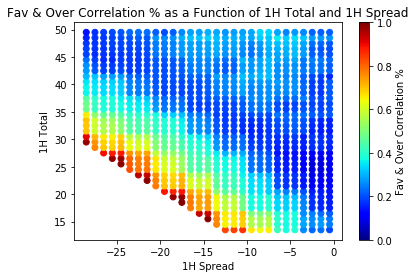

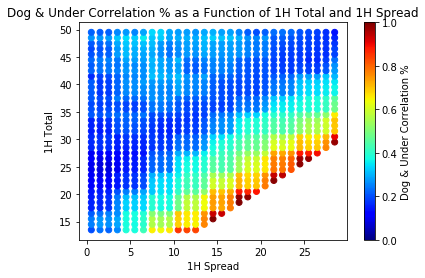

                Spread     Total  Spread/Total  cor_%_f/o
Spread        1.000000  0.228231      0.834816   0.402127
Total         0.228231  1.000000     -0.264807  -0.448255
Spread/Total  0.834816 -0.264807      1.000000   0.779090
cor_%_f/o     0.402127 -0.448255      0.779090   1.000000


In [1378]:
##calculate % chance of win/win in uncorreleated parlay (% fav * % over. etc)
df_cor_loop['f%*o%']=(df_cor_loop['fav_%']*df_cor_loop['over_%'])
df_cor_loop['d%*u%']=(df_cor_loop['dog_%']*df_cor_loop['under_%'])

## % chance of lower probability event (fav or over and dog or under) 
## This is used in calculating corr % because this would be the probability of a fully correlated parlay
df_cor_loop['f/o%_min']=df_cor_loop[['fav_%','over_%']].min(axis=1)
df_cor_loop['d/u%_min']=df_cor_loop[['dog_%','under_%']].min(axis=1)

## Correlation % is calculated by where the % of fav&over cover lands between a fully independent scenario of
   ## (% of fav covers) * (% of over covers) = (% of both fav & over cover), which is 0% correlated
   ## to a scenario of min((% of fav cover),(% of overs cover)) = (% of both fav & over cover), which is 100% correlated.
## Same thing for dog and under.
##SIMPLIFICATION - Probaby main simplification in this challenge. Assuming correlation % for a spread/total combo...
    ## stays constant regards of what the "fair" 50/50 spread and total are. 
    ## In other words, the correlation % of spread of -14.5 & total of 28.5 is the same regardless of whether -14.5 & 28.5 are the -110 lines or -400 or +800 etc
    ## This doesn't mean parlay odds are the same for both those scenarios, just how the parlay correlation adjustment alters the uncorrelated parlay odds. 
df_cor_loop['cor_%_f/o']=(df_cor_loop['f/o_%']-df_cor_loop['f%*o%'])/(df_cor_loop['f/o%_min']-df_cor_loop['f%*o%'])
df_cor_loop['cor_%_d/u']=(df_cor_loop['d/u_%']-df_cor_loop['d%*u%'])/(df_cor_loop['d/u%_min']-df_cor_loop['d%*u%'])
df_cor_loop['Spread/Total']=df_cor_loop['Spread']/df_cor_loop['Total']

# not everyone likes the "jet" color scheme, but i think it's a lot clearer for this dataset. 
plt.scatter(-1*df_cor_loop['Spread'],df_cor_loop['Total'], c=df_cor_loop['cor_%_f/o'], vmin=0, vmax=1, alpha=1,cmap='jet')
plt.title('Fav & Over Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Fav & Over Correlation %')
plt.show()

plt.scatter(df_cor_loop['Spread'],df_cor_loop['Total'], c=df_cor_loop['cor_%_d/u'], vmin=0, vmax=1, alpha=1,cmap='jet')
plt.title('Dog & Under Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Dog & Under Correlation %')
plt.show()

print(df_cor_loop[['Spread','Total','Spread/Total','cor_%_f/o']].corr())

In [1379]:
print('Fav/Over Corr Pct and Dog/Under Corr Pct is the same for a given spread/total. Max Difference/Error is: %.4f'
      % max(abs((df_cor_loop['cor_%_f/o']-df_cor_loop['cor_%_d/u']).min()),(df_cor_loop['cor_%_f/o']-df_cor_loop['cor_%_d/u']).max()))

Fav/Over Corr Pct and Dog/Under Corr Pct is the same for a given spread/total. Max Difference/Error is: 0.0029


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


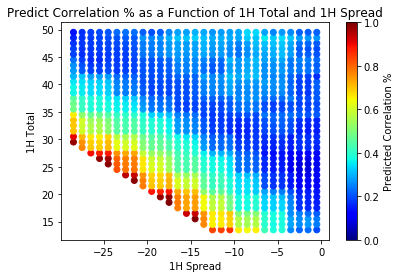

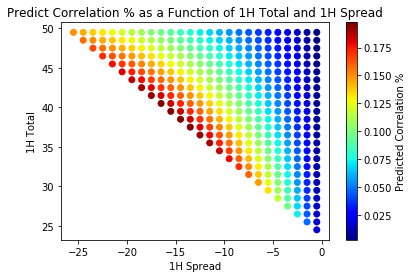

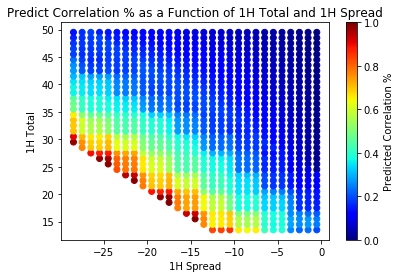

Spread       fav_%       dog_%       Total      over_%     under_%  \
count  937.000000  937.000000  937.000000  937.000000  937.000000  937.000000   
mean    13.193703    0.354710    0.645022   33.386873    0.375760    0.624008   
std      8.036714    0.195482    0.195550   10.019319    0.260041    0.260147   
min      0.500000    0.055329    0.315391   13.500000    0.046593    0.102798   
25%      6.500000    0.189672    0.456471   25.500000    0.145409    0.402837   
50%     12.500000    0.349058    0.650602   33.500000    0.354883    0.644967   
75%     19.500000    0.543001    0.810144   41.500000    0.596777    0.854450   
max     28.500000    0.684527    0.944617   49.500000    0.896913    0.953362   

            f/o_%       d/u_%       f%*o%       d%*u%    f/o%_min    d/u%_min  \
count  937.000000  937.000000  937.000000  937.000000  937.000000  937.000000   
mean     0.173644    0.442841    0.144555    0.413779    0.246388    0.515620   
std      0.147887    0.223027    0.143915    0.227523    0.173161    0.218670   
min      0.008736    0.046444    0.002578    0.032422    0.046593    0.102798   
25%      0.053194    0.264283    0.033398    0.226591    0.102310    0.335406   
50%      0.123083    0.419743    0.086537    0.392545    0.189672    0.526428   
75%      0.258785    0.620482    0.214830    0.597595    0.353329    0.695686   
max      0.627839    0.906724    0.613962    0.900562    0.684527    0.944617   

        cor_%_f/o   cor_%_d/u  Spread/Total  
count  937.000000  937.000000    937.000000  
mean     0.277116    0.276939      0.415309  
std      0.224511    0.224364      0.253609  
min      0.002981    0.002981      0.010101  
25%      0.113015    0.113093      0.200000  
50%      0.194211    0.194127      0.402597  
75%      0.393231    0.393078      0.604396  
max      1.000000    1.000000      0.966102

In [1380]:
## Want to smooth out the datapoints in the top corner. 
## The data is noisy there because there are less instances that fit the criteria of covering a high spread and/or a high total
## The goal is to keep as much of the high resolution data including the stepped regions that reflect inflection points at key numbers


## First cut away data in the corner above the (Spread + 23 = Total) line
## Remade it with a linear region based on extending the kept data outward

##seperated data
smooth_line=23
df_cor_smooth=df_cor_loop[(df_cor_loop['Spread']+smooth_line)<df_cor_loop['Total']]
df_cor_keep=df_cor_loop[(df_cor_loop['Spread']+smooth_line)>=df_cor_loop['Total']]

## did a linear fit based on the "kept" data to be used to replace the noisy removed data.
reg_cor = LinearRegression(fit_intercept=True).fit(df_cor_keep[['Spread','Spread/Total']], df_cor_keep['cor_%_f/o'])

## remade the noisy, low correlation corner using the linear fit and combined back together
cor_predict = reg_cor.predict(df_cor_smooth[['Spread','Spread/Total']])
df_cor_smooth['cor_%_f/o'] = cor_predict
df_cor_smooth['cor_%_d/u'] = cor_predict
df_cor=df_cor_smooth.append(df_cor_keep)

##comparison of original results and smoothing 

## plot original data
plt.scatter(-df_cor_loop['Spread'],df_cor_loop['Total'], c=df_cor_loop['cor_%_f/o'], vmin=0, vmax=1, alpha=1,cmap='jet')
plt.title('Predict Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Predicted Correlation %')
plt.show()

## plot just smoothed part
plt.scatter(-df_cor_smooth['Spread'],df_cor_smooth['Total'], c=df_cor_smooth['cor_%_f/o'],  alpha=1,cmap='jet')
plt.title('Predict Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Predicted Correlation %')
plt.show()

## plot final smooth
plt.scatter(-df_cor['Spread'],df_cor['Total'], c=df_cor['cor_%_f/o'], vmin=0, vmax=1, alpha=1,cmap='jet')
plt.title('Predict Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Predicted Correlation %')
plt.show()



df_cor.describe()


In [1381]:
## Interperolate current dataframe to add correlation % values for whole number spread/totals based on neighboring .5 spread/total values

for i_spread in np.arange(0.5,29,0.5):
    for i_total in np.arange(13.5,50,0.5):
        if (i_spread)==int(i_spread):
            if (i_total)==int(i_total):
                
                #both are new whole number spread total. average 4 surrounding values
                near1=df_cor[df_cor['Spread']==(i_spread+0.5)][df_cor['Total']==(i_total+0.5)]['cor_%_f/o'].max()
                near2=df_cor[df_cor['Spread']==(i_spread-0.5)][df_cor['Total']==(i_total+0.5)]['cor_%_f/o'].max()
                near3=df_cor[df_cor['Spread']==(i_spread-0.5)][df_cor['Total']==(i_total-0.5)]['cor_%_f/o'].max()
                near4=df_cor[df_cor['Spread']==(i_spread+0.5)][df_cor['Total']==(i_total-0.5)]['cor_%_f/o'].max()
                cor_pct_fo = statistics.mean([near1,near2,near3,near4])
                
                #established before that cor% for fav/over and dog/under are equal
                df_cor=df_cor.append(pd.DataFrame([[i_spread,i_total,cor_pct_fo,cor_pct_fo]],##continue next line
                columns = ['Spread','Total','cor_%_f/o','cor_%_d/u']), ignore_index=True)
                
            else:
                
                #just spread is a whole number
                near1=df_cor[df_cor['Spread']==(i_spread+0.5)][df_cor['Total']==(i_total)]['cor_%_f/o'].max()
                near2=df_cor[df_cor['Spread']==(i_spread-0.5)][df_cor['Total']==(i_total)]['cor_%_f/o'].max()
                cor_pct_fo = statistics.mean([near1,near2])
                
                df_cor=df_cor.append(pd.DataFrame([[i_spread,i_total,cor_pct_fo,cor_pct_fo]],##continue next line
                columns = ['Spread','Total','cor_%_f/o','cor_%_d/u']), ignore_index=True)
        else:
            if (i_total)==int(i_total):
                
                #just total is a whole number
                near1=df_cor[df_cor['Spread']==(i_spread)][df_cor['Total']==(i_total+0.5)]['cor_%_f/o'].max()
                near2=df_cor[df_cor['Spread']==(i_spread)][df_cor['Total']==(i_total-0.5)]['cor_%_f/o'].max()
                cor_pct_fo = statistics.mean([near1,near2])
                
                df_cor=df_cor.append(pd.DataFrame([[i_spread,i_total,cor_pct_fo,cor_pct_fo]],##continue next line
                columns = ['Spread','Total','cor_%_f/o','cor_%_d/u']), ignore_index=True)   

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be rei

In [1382]:
df_cor.head()

Spread  Spread/Total  Total  cor_%_d/u  cor_%_f/o     d%*u%  d/u%_min  \
0     0.5      0.020408   24.5   0.016802   0.016802  0.126193  0.315391   
1     0.5      0.019608   25.5   0.015729   0.015729  0.127051  0.315391   
2     0.5      0.018868   26.5   0.014737   0.014737  0.132383  0.315391   
3     0.5      0.018182   27.5   0.013817   0.013817  0.151199  0.315391   
4     0.5      0.017544   28.5   0.012961   0.012961  0.166031  0.315391   

      d/u_%     dog_%     f%*o%  f/o%_min     f/o_%     fav_%    over_%  \
0  0.145356  0.315391  0.410371  0.599495  0.429431  0.684527  0.599495   
1  0.146133  0.315391  0.408510  0.596777  0.427490  0.684527  0.596777   
2  0.153129  0.315391  0.396949  0.579887  0.417589  0.684527  0.579887   
3  0.168286  0.315391  0.356151  0.520287  0.373131  0.684527  0.520287   
4  0.190051  0.315391  0.323991  0.473306  0.347894  0.684527  0.473306   

    under_%  
0  0.400117  
1  0.402837  
2  0.419743  
3  0.479401  
4  0.526428

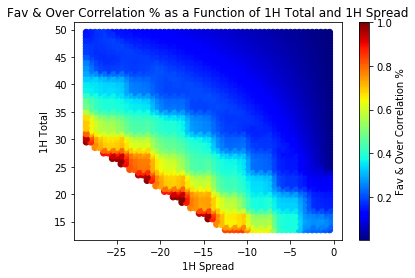

In [1383]:
# print again with interpelated values
plt.scatter(-1*df_cor['Spread'],df_cor['Total'], c=df_cor['cor_%_f/o'], alpha=1,cmap='jet')
plt.title('Fav & Over Correlation % as a Function of 1H Total and 1H Spread')
plt.xlabel('1H Spread')
plt.ylabel('1H Total')
plt.colorbar().set_label('Fav & Over Correlation %')
plt.show()



### Lookup Function for Correlation

In [1384]:
##input: Spread, Total 
##output: Correlation %

## reminder that correlation % for Fav/over and dog/under ended up being equal

def cor_look(spread,total):
    
    if spread >= total:
        cor_pct=1
    elif spread ==0:
        cor_pct=0
    else:
        try:
            cor_pct=df_cor[df_cor['Spread']==(abs(spread))][df_cor['Total']==(total)]['cor_%_f/o'].max()
        except: 
            print('\n Inputs out of range. \n\n Accetable range is a spread of: \n %.2f'% -df_cor['Spread'].max())
            print(' to %.2f'% df_cor['Spread'].max())
            print('\n and a Total of: \n %.2f'%df_cor['Total'].min())
            print(' to %.2f'%df_cor['Total'].max())
    
    return cor_pct

In [1385]:
#example
cor_look(-23,29.5)

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0.614631299689808

### American to Decimal Odds Function & Decimal to American Odds Function

In [1386]:
#input: american odds
#output: decimal odds

def am_to_dec(american_odds):
    
    if american_odds>0:
        dec_odds = 1+american_odds/100
    else:
        dec_odds = 1-(100/american_odds)
        
    return dec_odds

#input: decimal odds
#output: american odds

def dec_to_am(dec_odds):
    
    if dec_odds>2:
        american_odds = (dec_odds-1)*100
    else:
        american_odds = -100/(dec_odds-1)
        
    return american_odds

## Top Level Function for H1 Parlay Pricing

In [1387]:
#inputs: consensus full-game point spread & total, desired first half point spread/total and prices in american odds
#output: parlay price in american odds

def parlay_price(spread,total,H1_spread,H1_spread_price,H1_total,H1_total_price):
    
    # get win/push/loss probability for spread and total using previous defined function
    (prob_win_spread,prob_push_spread,dec_spread_model,prob_win_total,prob_push_total,dec_total_model)=odds(spread,total,H1_spread,H1_total)
    
    # calculate probability of the 3 push scenarios
    prob_spread_win_total_push = prob_win_spread * prob_push_total
    prob_total_win_spread_push = prob_win_total * prob_push_spread
    prob_push_push = prob_push_spread * prob_push_total
    prob_win_min = min(prob_win_spread,prob_win_total)
    
    
    # get correlation using other subfunction
    cor_pct = cor_look(H1_spread,H1_total)
    
    #calculate what the independent win/win probably would be 
    indep_prob_win_win = prob_win_spread * prob_win_total
    
    #calculate lower probability between spread and total covering to establish probability of corr=1 parlay
    min_prob_total_spread = min(prob_win_spread,prob_win_total)
    
    #adjust  win/win probability based on corr %
    prob_win_win = cor_pct*(prob_win_min - indep_prob_win_win)+indep_prob_win_win
        
    # convert from american to decimal odds
    dec_odd_spread = am_to_dec(H1_spread_price)
    dec_odd_total = am_to_dec(H1_total_price)

    indep_parlay_dec = dec_odd_spread*dec_odd_total
    
    # sum of probability of each outcome * each outcome decimal odds = 1
    # so 1 = win/win% * parlay odd + 1*push/push% + spread_odds*win-spread/push-total% + total_odds*win-total/push-spread%
    # rearrange to solve for parlay odds
    cor_parlay_dec= ((1 - 1*prob_push_push - dec_odd_spread*prob_spread_win_total_push - dec_odd_total*prob_total_win_spread_push)/prob_win_win).max()
    cor_parlay_am = dec_to_am(cor_parlay_dec)
    
    # calculate parlay odds just based on the H1 model. 
    # So accounting for spread/total price differences vs inputs but not accounting for correlation
    # useful as a check to see how much delta is from H1 model and how much is from correlation
    indep_model_parlay_dec= ((1 - 1*prob_push_push - dec_odd_spread*prob_spread_win_total_push - dec_odd_total*prob_total_win_spread_push)/indep_prob_win_win).max()
    
    # Earned Value for betting correlated parlay at uncorrelated odds
    EV=indep_parlay_dec/cor_parlay_dec-1
    
    print('\n Uncorrelated Parlay - Decimal: \n %.2f' % indep_parlay_dec)
    print(' Uncorrelated H1 Model Parlay - Decimal: \n %.2f' % indep_model_parlay_dec)
    print(' Correlated Parlay Price - Decimal: \n %.2f' % cor_parlay_dec)
    print('\n Correlation Percent: \n %.2f' % cor_pct)
    print(' Earned Value: \n %.2f' % EV)
    print('\n Correlated Parlay Price - American: \n %.0f' % cor_parlay_am)
   
    return pd.Series([cor_parlay_am, EV])

# Interface for Parlay Price

In [1388]:
# should add checks and feedback on if the values entered make sense
# these entries would be boxes to populate on the GUI
spread = -36.5
total = 51
H1_spread = -22
H1_spread_price = 104
H1_total = 28.5
H1_total_price = -110
([cor_parlay_am, EV])=parlay_price(spread,total,H1_spread,H1_spread_price,H1_total,H1_total_price)



 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.489
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.32

 Probability Over covers: 
0.432
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.60
 Correlated Parlay Price - Decimal: 
 2.80

 Correlation Percent: 
 0.62
 Earned Value: 
 0.39

 Correlated Parlay Price - American: 
 180


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Test the Function using the Data_test set by Comparing projected EV to actual results

In [1389]:
data_test_fav = data_test[data_test['line_p']<=0]
data_test_dog = data_test[data_test['line_p']>0]
data_test_fav.head()

gameid  line_p  line_p_mon  tot_p  tot_p_omon  tot_p_umon  line_p_h1  \
12631   10327   -10.0        -112   64.0      -112.0      -102.0       -6.0   
12635   10329   -38.5        -106   58.5      -102.0      -112.0      -24.0   
12638   10330   -13.5        -112   56.0      -102.0      -112.0       -7.5   
12643   10333   -21.5         102   58.0       100.0      -115.0      -12.5   
12652   10337    -4.5        -102   40.5      -110.0      -104.0       -3.0   

       line_p_mon_h1  tot_p_h1  tot_p_omon_h1  tot_p_umon_h1  season  week  \
12631         -112.0      32.0         -107.0         -107.0    2016     1   
12635         -106.0      34.5         -119.0          104.0    2016     1   
12638         -100.0      28.0         -111.0         -103.0    2016     1   
12643         -120.0      31.0         -107.0         -107.0    2016     1   
12652         -103.0      20.0         -113.0         -101.0    2016     1   

       diff_h1  tot_h1  
12631     -2.0    22.0  
12635    -56.0    56.0  
12638     -3.0    31.0  
12643     10.0    16.0  
12652    -10.0    10.0

In [1390]:
#run parlay pricer on all H1 spreads and totals in the "test" data set. 
#add column for parlay price and the project EV against a straight parlay using the independent odds. 
data_test_fav[['cor_par','EV']]= data_test_fav.apply(lambda x: parlay_price(x['line_p'],x['tot_p'],x['line_p_h1'],x['line_p_mon_h1'],x['tot_p_h1'],x['tot_p_omon_h1']),axis =1)
data_test_dog[['cor_par','EV']]= data_test_dog.apply(lambda x: parlay_price(x['line_p'],x['tot_p'],x['line_p_h1'],x['line_p_mon_h1'],x['tot_p_h1'],x['tot_p_umon_h1']),axis =1)



 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.78

 Probability Over covers: 
0.543
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 3.20

 Correlation Percent: 
 0.12
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 220


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.78

 Probability Over covers: 
0.543
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 3.20

 Correlation Percent: 
 0.12
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 220


 Model Decimal Odds to bet Fav: 
2.09

 Probability Fav covers: 
0.463
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.528
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.80
 Uncorrelated H1 Model Parlay - Decimal: 
 3.49
 Correlated Parlay Price - Decimal: 
 2.97

 Correlation Percent: 
 0.19
 Earned Value: 
 0.28

 Correlated Parlay Price - American: 
 197


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.519
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.09

 Probability Over covers: 
0.462
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 4.04
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.20
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 240


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.90

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Fav covers: 
0.493
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 3.67
 Correlated Parlay Price - Decimal: 
 3.14

 Correlation Percent: 
 0.19
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 214


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.510
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.04

 Probability Over covers: 
0.491
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.87
 Correlated Parlay Price - Decimal: 
 2.99

 Correlation Percent: 
 0.31
 Earned Value: 
 0.21

 Correlated Parlay Price - American: 
 199


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.88

 Prob

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 3.50

 Correlation Percent: 
 0.11
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 250


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.513
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.69
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.13
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.525
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.19

 Probability Over covers: 
0.441
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.17
 Correlated Parlay Price - Decimal: 
 2.78

 Correlation Percent: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.29

 Probability Over covers: 
0.437
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.50
 Correlated Parlay Price - Decimal: 
 3.84

 Correlation Percent: 
 0.17
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 284


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.474
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.16

 Probability Over covers: 
0.463
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.43
 Correlated Parlay Price - Decimal: 
 3.36

 Correlation Percent: 
 0.28
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 236


 Model Decimal Odds to bet Fav: 
1.81

 Probability Fav covers: 
0.536
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.12

 Pr

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.492
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.04
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.05
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 286


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.542
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.532
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.47
 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent: 
 0.11
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 217


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.23

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 3.81
 Correlated Parlay Price - Decimal: 
 3.36

 Correlation Percent: 
 0.14
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 236


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.498
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.32

 Probability Over covers: 
0.432
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.88
 Uncorrelated H1 Model Parlay - Decimal: 
 4.65
 Correlated Parlay Price - Decimal: 
 3.77

 Correlation Percent: 
 0.23
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 277


 Model Decimal Odds to bet Fav: 
2.07

 Probability Fav covers: 
0.482
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.52

 Probability Over covers: 
0.384
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 5.23
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Probability Fav covers: 
0.556
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.80

 Probability Over covers: 
0.536
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.24
 Correlated Parlay Price - Decimal: 
 3.02

 Correlation Percent: 
 0.09
 Earned Value: 
 0.28

 Correlated Parlay Price - American: 
 202


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.50

 Probability Over covers: 
0.400
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.94
 Correlated Parlay Price - Decimal: 
 3.71

 Correlation Percent: 
 0.32
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 271


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.489
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.03

 Prob

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.74

 Probability Over covers: 
0.555
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.28
 Uncorrelated H1 Model Parlay - Decimal: 
 3.42
 Correlated Parlay Price - Decimal: 
 3.32

 Correlation Percent: 
 0.04
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 232


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.497
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.14

 Probability Over covers: 
0.451
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.17
 Correlated Parlay Price - Decimal: 
 3.05

 Correlation Percent: 
 0.36
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 205


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.47

 Pr

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price - Decimal: 
 3.39

 Correlation Percent: 
 0.30
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 239


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.473
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.98

 Probability Over covers: 
0.504
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.06
 Correlated Parlay Price - Decimal: 
 3.57

 Correlation Percent: 
 0.14
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 257


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.507
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.22

 Probability Over covers: 
0.434
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.45
 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.01
 Correlated Parlay Price - Decimal: 
 3.80

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 280


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.495
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.97

 Probability Over covers: 
0.491
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.09
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 3.59

 Correlation Percent: 
 0.07
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 259


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.98

 Probability Over covers: 
0.487
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 3.66


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent: 
 0.17
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 217


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.543
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.509
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.90
 Uncorrelated H1 Model Parlay - Decimal: 
 3.62
 Correlated Parlay Price - Decimal: 
 3.14

 Correlation Percent: 
 0.18
 Earned Value: 
 0.24

 Correlated Parlay Price - American: 
 214


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.522
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.73
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.15
 Earned Value: 
 0.10

 Correlated Parlay

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Fav: 
2.10

 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.25

 Probability Over covers: 
0.429
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.84
 Uncorrelated H1 Model Parlay - Decimal: 
 4.73
 Correlated Parlay Price - Decimal: 
 3.96

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 296


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.487
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.02
 Correlated Parlay Price - Decimal: 
 3.64

 Correlation Percent: 
 0.11
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 264


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Mod

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated H1 Model Parlay - Decimal: 
 4.28
 Correlated Parlay Price - Decimal: 
 2.95

 Correlation Percent: 
 0.42
 Earned Value: 
 0.29

 Correlated Parlay Price - American: 
 195


 Model Decimal Odds to bet Fav: 
1.87

 Probability Fav covers: 
0.535
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.543
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 3.44
 Correlated Parlay Price - Decimal: 
 3.25

 Correlation Percent: 
 0.07
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 225


 Model Decimal Odds to bet Fav: 
2.09

 Probability Fav covers: 
0.462
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.26

 Probability Over covers: 
0.442
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 4.77
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.58
 Uncorrelated H1 Model Parlay - Decimal: 
 3.65
 Correlated Parlay Price - Decimal: 
 3.43

 Correlation Percent: 
 0.08
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 243


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.78

 Probability Over covers: 
0.562
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.52
 Uncorrelated H1 Model Parlay - Decimal: 
 3.54
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.05
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 240


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.493

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.509
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 3.19

 Correlation Percent: 
 0.17
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 219


 Model Decimal Odds to bet Fav: 
2.09

 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.98

 Probability Over covers: 
0.504
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.06
 Uncorrelated H1 Model Parlay - Decimal: 
 4.15
 Correlated Parlay Price - Decimal: 
 3.84

 Correlation Percent: 
 0.08
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 284


 Model Decimal Odds to bet Fav: 
2.19

 Probability Fav covers: 
0.442
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.27

 Probability Over covers: 
0.426
 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 227


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.532
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.55
 Correlated Parlay Price - Decimal: 
 3.48

 Correlation Percent: 
 0.02
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 248


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.04

 Probability Over covers: 
0.473
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 3.92
 Correlated Parlay Price - Decimal: 
 3.29

 Correlation Percent: 
 0.19
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 229


 Model Decimal Odds to bet Fav: 
1.89

 Probab

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 3.73
 Correlated Parlay Price - Decimal: 
 3.21

 Correlation Percent: 
 0.20
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 221


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.27

 Probability Over covers: 
0.441
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.60
 Correlated Parlay Price - Decimal: 
 2.80

 Correlation Percent: 
 0.62
 Earned Value: 
 0.35

 Correlated Parlay Price - American: 
 180


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.532
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 3.65
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.99

 Probability Over covers: 
0.486
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.12
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 241


 Model Decimal Odds to bet Fav: 
2.09

 Probability Fav covers: 
0.478
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.67

 Probability Over covers: 
0.362
 Probability Total Pushes: 
0.033

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 5.60
 Correlated Parlay Price - Decimal: 
 4.62

 Correlation Percent: 
 0.20
 Earned Value: 
 -0.19

 Correlated Parlay Price - American: 
 362


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.506
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Pr

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.543
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 3.42
 Correlated Parlay Price - Decimal: 
 2.97

 Correlation Percent: 
 0.18
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 197


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.73

 Probability Over covers: 
0.578
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.43
 Uncorrelated H1 Model Parlay - Decimal: 
 3.55
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent: 
 0.05
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 242


 Model Decimal Odds to bet Fav: 
1.83

 Probability Fav covers: 
0.546
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.22

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.07

 Probability Over covers: 
0.467
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 4.33
 Correlated Parlay Price - Decimal: 
 4.02

 Correlation Percent: 
 0.07
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 302


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.80

 Probability Over covers: 
0.555
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.58
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent: 
 0.12
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 238


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.525
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.72

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.82

 Probability Over covers: 
0.530
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.88
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 3.65

 Correlation Percent: 
 0.06
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 265


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.520
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.80
 Uncorrelated H1 Model Parlay - Decimal: 
 3.64
 Correlated Parlay Price - Decimal: 
 3.53

 Correlation Percent: 
 0.03
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 253


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.95

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.465
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.470
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.90
 Uncorrelated H1 Model Parlay - Decimal: 
 4.28
 Correlated Parlay Price - Decimal: 
 3.21

 Correlation Percent: 
 0.29
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 221


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.511
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.70
 Uncorrelated H1 Model Parlay - Decimal: 
 3.94
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.17
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 240


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.495
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.85

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Correlation Percent: 
 0.22
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 216


 Model Decimal Odds to bet Fav: 
2.09

 Probability Fav covers: 
0.463
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.472
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.30
 Correlated Parlay Price - Decimal: 
 3.65

 Correlation Percent: 
 0.16
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 265


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.519
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.58
 Correlated Parlay Price - Decimal: 
 3.15

 Correlation Percent: 
 0.16
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 215


 Model Decimal 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.03
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.14
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 251


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.504
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.487
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 3.95
 Correlated Parlay Price - Decimal: 
 2.90

 Correlation Percent: 
 0.37
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 190


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.524
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.02

 Probability Over covers: 
0.495
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 3.86
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.528
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 3.50
 Correlated Parlay Price - Decimal: 
 3.04

 Correlation Percent: 
 0.17
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 204


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.505
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.65

 Probability Over covers: 
0.585
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.44
 Uncorrelated H1 Model Parlay - Decimal: 
 3.16
 Correlated Parlay Price - Decimal: 
 2.96

 Correlation Percent: 
 0.09
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 196


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.454
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 4.05
 Correlated Parlay Price - Decimal: 
 3.74

 Correlation Percent: 
 0.09
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 274


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.531
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.544
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 3.46
 Correlated Parlay Price - Decimal: 
 3.35

 Correlation Percent: 
 0.04
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 235


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.497
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.92

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.75

 Probability Over covers: 
0.573
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 3.35
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.12
 Earned Value: 
 0.24

 Correlated Parlay Price - American: 
 208


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.63

 Probability Over covers: 
0.614
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.25
 Uncorrelated H1 Model Parlay - Decimal: 
 3.13
 Correlated Parlay Price - Decimal: 
 2.93

 Correlation Percent: 
 0.10
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 193


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.485
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.02

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.504
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 3.59
 Correlated Parlay Price - Decimal: 
 3.16

 Correlation Percent: 
 0.14
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 216


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.522
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.528
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.44
 Uncorrelated H1 Model Parlay - Decimal: 
 3.63
 Correlated Parlay Price - Decimal: 
 2.97

 Correlation Percent: 
 0.25
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 197


 Model Decimal Odds to bet Fav: 
2.06

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.86

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.65
 Correlated Parlay Price - Decimal: 
 3.31

 Correlation Percent: 
 0.12
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 231


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.93

 Probability Over covers: 
0.499
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 3.94
 Correlated Parlay Price - Decimal: 
 3.65

 Correlation Percent: 
 0.08
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 265


 Model Decimal Odds to bet Fav: 
2.17

 Probability Fav covers: 
0.462
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.48

 Probability Over covers: 
0.404
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 5.37
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Fav covers: 
0.498
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.541
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.51
 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price - Decimal: 
 3.46

 Correlation Percent: 
 0.05
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 246


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.94

 Probability Over covers: 
0.497
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.99
 Correlated Parlay Price - Decimal: 
 3.77

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 277


 Model Decimal Odds to bet Fav: 
1.89

 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.28

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.531
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 3.24

 Correlation Percent: 
 0.17
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 224


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.498
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 3.86
 Correlated Parlay Price - Decimal: 
 3.61

 Correlation Percent: 
 0.07
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 261


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.522
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.94

 Probability Over covers: 
0.515
 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 2.96

 Correlation Percent: 
 0.27
 Earned Value: 
 0.29

 Correlated Parlay Price - American: 
 196


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.511
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 3.88
 Correlated Parlay Price - Decimal: 
 3.61

 Correlation Percent: 
 0.08
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 261


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.545
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.88
 Uncorrelated H1 Model Parlay - Decimal: 
 3.76
 Correlated Parlay Price - Decimal: 
 3.59

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.514
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.01

 Probability Over covers: 
0.481
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 3.90
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.20
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.519
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.470
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.96
 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent: 
 0.27
 Earned Value: 
 0.21

 Correlated Parlay Price - American: 
 217


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.72

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.504
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.08

 Probability Over covers: 
0.481
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.99
 Correlated Parlay Price - Decimal: 
 2.97

 Correlation Percent: 
 0.35
 Earned Value: 
 0.29

 Correlated Parlay Price - American: 
 197


 Model Decimal Odds to bet Fav: 
1.78

 Probability Fav covers: 
0.542
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.522
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.90
 Uncorrelated H1 Model Parlay - Decimal: 
 3.28
 Correlated Parlay Price - Decimal: 
 3.12

 Correlation Percent: 
 0.06
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 212


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.16

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.89
 Correlated Parlay Price - Decimal: 
 3.46

 Correlation Percent: 
 0.14
 Earned Value: 
 0.21

 Correlated Parlay Price - American: 
 246


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.525
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.59
 Uncorrelated H1 Model Parlay - Decimal: 
 3.84
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.14
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 241


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.09

 Probability Over covers: 
0.477
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.30
 Correlated Parlay Price - Decimal: 
 3.83

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 3.81
 Correlated Parlay Price - Decimal: 
 3.34

 Correlation Percent: 
 0.15
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 234


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.01

 Probability Over covers: 
0.480
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.13
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.07
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 286


 Model Decimal Odds to bet Fav: 
1.86

 Probability Fav covers: 
0.520
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.09

 Probability Over covers: 
0.478
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.88
 Uncorrelated H1 Model Parlay - Decimal: 
 3.89
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.76

 Probability Over covers: 
0.569
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.65
 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.07
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 241


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.505
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.492
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 3.88
 Correlated Parlay Price - Decimal: 
 3.52

 Correlation Percent: 
 0.11
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 252


 Model Decimal Odds to bet Fav: 
1.87

 Probability Fav covers: 
0.534
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.03

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.510
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.80

 Probability Over covers: 
0.556
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.40
 Correlated Parlay Price - Decimal: 
 2.88

 Correlation Percent: 
 0.23
 Earned Value: 
 0.31

 Correlated Parlay Price - American: 
 188


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.82

 Probability Over covers: 
0.550
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 3.55
 Correlated Parlay Price - Decimal: 
 3.10

 Correlation Percent: 
 0.18
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 210


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.76

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.96
 Correlated Parlay Price - Decimal: 
 2.98

 Correlation Percent: 
 0.34
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 198


 Model Decimal Odds to bet Fav: 
1.80

 Probability Fav covers: 
0.554
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.472
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.32
 Uncorrelated H1 Model Parlay - Decimal: 
 3.69
 Correlated Parlay Price - Decimal: 
 2.82

 Correlation Percent: 
 0.39
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 182


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.471
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.80
 Uncorrelated H1 Model Parlay - Decimal: 
 4.08
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.40
 Correlated Parlay Price - Decimal: 
 3.75

 Correlation Percent: 
 0.16
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 275


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.532
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 3.69
 Correlated Parlay Price - Decimal: 
 3.46

 Correlation Percent: 
 0.08
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 246


 Model Decimal Odds to bet Fav: 
2.16

 Probability Fav covers: 
0.448
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.25

 Probability Over covers: 
0.429
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.89
 Correlated Parlay Price - Decimal: 
 3.12

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Fav covers: 
0.455
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.11

 Probability Over covers: 
0.457
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 4.50
 Correlated Parlay Price - Decimal: 
 3.16

 Correlation Percent: 
 0.36
 Earned Value: 
 0.30

 Correlated Parlay Price - American: 
 216


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.65
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent: 
 0.08
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 242


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Prob

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.542
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 3.45

 Correlation Percent: 
 0.09
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 245


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.82

 Probability Over covers: 
0.550
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.47

 Correlation Percent: 
 0.08
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 247


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.519
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.514
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 3.63
 Correlated Parlay Price - Decimal: 
 3.09

 Correlation Percent: 
 0.19
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 209


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.543
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.16

 Probability Over covers: 
0.463
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 3.98
 Correlated Parlay Price - Decimal: 
 2.88

 Correlation Percent: 
 0.45
 Earned Value: 
 0.24

 Correlated Parlay Price - American: 
 188


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.80

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.532
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 3.46
 Correlated Parlay Price - Decimal: 
 2.99

 Correlation Percent: 
 0.18
 Earned Value: 
 0.30

 Correlated Parlay Price - American: 
 199


 Model Decimal Odds to bet Fav: 
1.87

 Probability Fav covers: 
0.535
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.74

 Probability Over covers: 
0.574
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 3.26
 Correlated Parlay Price - Decimal: 
 3.07

 Correlation Percent: 
 0.08
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 207


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.532
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.11

 Probability Over covers: 
0.457
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 3.96
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.32
 Earned Value: 
 0.33

 Correlated Parlay Price - American: 
 208


 Model Decimal Odds to bet Fav: 
2.07

 Probability Fav covers: 
0.484
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.00

 Probability Over covers: 
0.499
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.14
 Correlated Parlay Price - Decimal: 
 2.86

 Correlation Percent: 
 0.45
 Earned Value: 
 0.36

 Correlated Parlay Price - American: 
 186


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.89

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.19
 Correlated Parlay Price - Decimal: 
 3.13

 Correlation Percent: 
 0.34
 Earned Value: 
 0.27

 Correlated Parlay Price - American: 
 213


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.07

 Probability Over covers: 
0.482
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.53
 Uncorrelated H1 Model Parlay - Decimal: 
 3.84
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent: 
 0.19
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 226


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.525
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 3.42
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.92
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent: 
 0.16
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 242


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.526
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.504
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 3.64
 Correlated Parlay Price - Decimal: 
 2.64

 Correlation Percent: 
 0.42
 Earned Value: 
 0.32

 Correlated Parlay Price - American: 
 164


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.02

 Probability Over covers: 
0.479
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.10
 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 3.71
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.10
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 240


 Model Decimal Odds to bet Fav: 
1.87

 Probability Fav covers: 
0.535
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 3.51
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.07
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 230


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.516
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.80

 Probability Over covers: 
0.536
 Probability Total Pushes: 
0.035

 Unco

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.543
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.513
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 3.59
 Correlated Parlay Price - Decimal: 
 3.29

 Correlation Percent: 
 0.11
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 229


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.80

 Probability Over covers: 
0.555
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 3.43

 Correlation Percent: 
 0.03
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 243


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.498
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.77

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 244


 Model Decimal Odds to bet Fav: 
1.87

 Probability Fav covers: 
0.536
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.14

 Probability Over covers: 
0.467
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.00
 Correlated Parlay Price - Decimal: 
 3.04

 Correlation Percent: 
 0.36
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 204


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.505
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.78

 Probability Over covers: 
0.562
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 3.40
 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent: 
 0.09
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 217


 Model Decimal Odds to bet Fav: 
2.00

 Proba

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.84
 Correlated Parlay Price - Decimal: 
 3.19

 Correlation Percent: 
 0.22
 Earned Value: 
 0.17

 Correlated Parlay Price - American: 
 219


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.13

 Probability Over covers: 
0.452
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 4.20
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.36
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 208


 Model Decimal Odds to bet Fav: 
2.10

 Probability Fav covers: 
0.476
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.94

 Probability Over covers: 
0.516
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.58
 Uncorrelated H1 Model Parlay - Decimal: 
 4.07
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.50
 Correlated Parlay Price - Decimal: 
 2.93

 Correlation Percent: 
 0.26
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 193


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.516
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.49
 Uncorrelated H1 Model Parlay - Decimal: 
 3.78
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.16
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 230


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.08

 Probability Over covers: 
0.464
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 4.09
 Correlated Parlay Price - Decimal: 
 3.54

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.65
 Correlated Parlay Price - Decimal: 
 3.36

 Correlation Percent: 
 0.10
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 236


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.93

 Probability Over covers: 
0.519
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.71
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.06
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 251


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.510
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.522
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 3.49
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.52
 Uncorrelated H1 Model Parlay - Decimal: 
 3.74
 Correlated Parlay Price - Decimal: 
 3.50

 Correlation Percent: 
 0.08
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 250


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.76

 Probability Over covers: 
0.567
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.45
 Correlated Parlay Price - Decimal: 
 3.35

 Correlation Percent: 
 0.04
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 235


 Model Decimal Odds to bet Fav: 
2.13

 Probability Fav covers: 
0.454
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.559
 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent: 
 0.04
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 242


 Model Decimal Odds to bet Fav: 
2.24

 Probability Fav covers: 
0.432
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.12

 Probability Over covers: 
0.455
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 4.78
 Correlated Parlay Price - Decimal: 
 3.85

 Correlation Percent: 
 0.20
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 285


 Model Decimal Odds to bet Fav: 
1.81

 Probability Fav covers: 
0.553
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.15

 Probability Over covers: 
0.464
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 3.89
 Correlated Parlay Price - Decimal: 
 3.33

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Uncorrelated H1 Model Parlay - Decimal: 
 4.91
 Correlated Parlay Price - Decimal: 
 3.37

 Correlation Percent: 
 0.42
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 237


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.01

 Probability Over covers: 
0.481
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.05
 Correlated Parlay Price - Decimal: 
 3.54

 Correlation Percent: 
 0.14
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 254


 Model Decimal Odds to bet Fav: 
2.21

 Probability Fav covers: 
0.453
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.77

 Probability Over covers: 
0.349
 Probability Total Pushes: 
0.033

 Uncorrelated Parlay - Decimal: 
 3.80
 Uncorrelated H1 Model Parlay - Decimal: 
 6.13
 Correlated Parlay Price - Decimal: 
 3.55

 Correlation Percent: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.476
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.548
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.16
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.524
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.02

 Probability Over covers: 
0.478
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 3.85
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 
 0.23
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 218


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.517
 Probability Spread Pushes: 
0.000

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.84
 Correlated Parlay Price - Decimal: 
 3.52

 Correlation Percent: 
 0.09
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 252


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 3.85
 Correlated Parlay Price - Decimal: 
 3.59

 Correlation Percent: 
 0.08
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 259


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.02

 Probability Over covers: 
0.478
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.88
 Uncorrelated H1 Model Parlay - Decimal: 
 3.95
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.76
 Correlated Parlay Price - Decimal: 
 3.44

 Correlation Percent: 
 0.09
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 244


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.518
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent: 
 0.15
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 226


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.487
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.09
 Correlated Parlay Price - Decimal: 
 3.85

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 3.45
 Correlated Parlay Price - Decimal: 
 2.90

 Correlation Percent: 
 0.21
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 190


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.493
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.75
 Uncorrelated H1 Model Parlay - Decimal: 
 3.65
 Correlated Parlay Price - Decimal: 
 2.84

 Correlation Percent: 
 0.33
 Earned Value: 
 0.32

 Correlated Parlay Price - American: 
 184


 Model Decimal Odds to bet Fav: 
1.79

 Probability Fav covers: 
0.558
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.515
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.36
 Uncorrelated H1 Model Parlay - Decimal: 
 3.36
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated Parlay Price - Decimal: 
 3.25

 Correlation Percent: 
 0.16
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 225


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.476
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.80

 Probability Over covers: 
0.536
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 3.66
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent: 
 0.14
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 226


 Model Decimal Odds to bet Fav: 
2.10

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.06

 Probability Over covers: 
0.468
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.91
 Uncorrelated H1 Model Parlay - Decimal: 
 4.35
 Correlated Parlay Price - Decimal: 
 3.36

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.40
 Correlated Parlay Price - Decimal: 
 3.27

 Correlation Percent: 
 0.32
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 227


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.485
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.94

 Probability Over covers: 
0.498
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.86
 Uncorrelated H1 Model Parlay - Decimal: 
 3.87
 Correlated Parlay Price - Decimal: 
 3.53

 Correlation Percent: 
 0.09
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 253


 Model Decimal Odds to bet Fav: 
1.89

 Probability Fav covers: 
0.530
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.03

 Probability Over covers: 
0.476
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.525
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.554
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.44
 Correlated Parlay Price - Decimal: 
 3.19

 Correlation Percent: 
 0.10
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 219


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.82

 Probability Over covers: 
0.550
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.57
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent: 
 0.07
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 238


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.11

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.52
 Uncorrelated H1 Model Parlay - Decimal: 
 3.44
 Correlated Parlay Price - Decimal: 
 2.95

 Correlation Percent: 
 0.19
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 195


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.482
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.93

 Probability Over covers: 
0.499
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.91
 Uncorrelated H1 Model Parlay - Decimal: 
 3.88
 Correlated Parlay Price - Decimal: 
 3.49

 Correlation Percent: 
 0.11
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 249


 Model Decimal Odds to bet Fav: 
2.15

 Probability Fav covers: 
0.466
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.04

 Probability Over covers: 
0.473
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.39
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.504
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.15

 Probability Over covers: 
0.464
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price - Decimal: 
 2.98

 Correlation Percent: 
 0.44
 Earned Value: 
 0.34

 Correlated Parlay Price - American: 
 198


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.524
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.520
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.56
 Uncorrelated H1 Model Parlay - Decimal: 
 3.42
 Correlated Parlay Price - Decimal: 
 2.94

 Correlation Percent: 
 0.18
 Earned Value: 
 0.21

 Correlated Parlay Price - American: 
 194


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.485
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.94

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.505
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 3.88
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.09
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 258


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.507
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 3.91
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.12
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 251


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.90

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.505
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.560
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.41
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.05
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.87

 Probability Fav covers: 
0.535
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 3.47
 Correlated Parlay Price - Decimal: 
 3.29

 Correlation Percent: 
 0.06
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 229


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.98

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.502
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.00
 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price - Decimal: 
 3.01

 Correlation Percent: 
 0.22
 Earned Value: 
 0.33

 Correlated Parlay Price - American: 
 201


 Model Decimal Odds to bet Fav: 
1.86

 Probability Fav covers: 
0.520
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.515
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.93
 Uncorrelated H1 Model Parlay - Decimal: 
 3.47
 Correlated Parlay Price - Decimal: 
 2.88

 Correlation Percent: 
 0.22
 Earned Value: 
 0.36

 Correlated Parlay Price - American: 
 188


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.96

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 3.63
 Correlated Parlay Price - Decimal: 
 2.97

 Correlation Percent: 
 0.25
 Earned Value: 
 0.38

 Correlated Parlay Price - American: 
 197


 Model Decimal Odds to bet Fav: 
2.13

 Probability Fav covers: 
0.454
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.73

 Probability Over covers: 
0.559
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated Parlay Price - Decimal: 
 3.50

 Correlation Percent: 
 0.07
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 250


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.73

 Probability Over covers: 
0.578
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.47
 Uncorrelated H1 Model Parlay - Decimal: 
 3.19
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.57
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.18
 Earned Value: 
 0.27

 Correlated Parlay Price - American: 
 208


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.495
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.560
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.48
 Correlated Parlay Price - Decimal: 
 3.25

 Correlation Percent: 
 0.09
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 225


 Model Decimal Odds to bet Fav: 
2.10

 Probability Fav covers: 
0.476
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.553
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.80
 Uncorrelated H1 Model Parlay - Decimal: 
 3.80
 Correlated Parlay Price - Decimal: 
 3.44

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.88
 Uncorrelated H1 Model Parlay - Decimal: 
 5.42
 Correlated Parlay Price - Decimal: 
 3.11

 Correlation Percent: 
 0.62
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 211


 Model Decimal Odds to bet Fav: 
1.80

 Probability Fav covers: 
0.555
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.24

 Probability Over covers: 
0.432
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.32
 Uncorrelated H1 Model Parlay - Decimal: 
 4.02
 Correlated Parlay Price - Decimal: 
 3.31

 Correlation Percent: 
 0.27
 Earned Value: 
 0.31

 Correlated Parlay Price - American: 
 231


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.502
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.67
 Uncorrelated H1 Model Parlay - Decimal: 
 3.77
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 3.51
 Correlated Parlay Price - Decimal: 
 3.23

 Correlation Percent: 
 0.10
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 223


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.539
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 
 0.15
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 218


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.510
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 3.42
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 4.01
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.27
 Earned Value: 
 0.17

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.525
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.00
 Uncorrelated H1 Model Parlay - Decimal: 
 3.61
 Correlated Parlay Price - Decimal: 
 3.21

 Correlation Percent: 
 0.14
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 221


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 3.75
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.54
 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated Parlay Price - Decimal: 
 3.47

 Correlation Percent: 
 0.07
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 247


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.476
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.72

 Probability Over covers: 
0.560
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 3.50
 Correlated Parlay Price - Decimal: 
 3.22

 Correlation Percent: 
 0.11
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 222


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.532
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.529
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.31

 Probability Over covers: 
0.418
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.24
 Correlated Parlay Price - Decimal: 
 3.14

 Correlation Percent: 
 0.39
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 214


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.513
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 3.62

 Correlation Percent: 
 0.03
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 262


 Model Decimal Odds to bet Fav: 
2.10

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.00

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.48
 Correlated Parlay Price - Decimal: 
 2.96

 Correlation Percent: 
 0.19
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 196


 Model Decimal Odds to bet Fav: 
1.86

 Probability Fav covers: 
0.537
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.98

 Probability Over covers: 
0.504
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.53
 Uncorrelated H1 Model Parlay - Decimal: 
 3.69
 Correlated Parlay Price - Decimal: 
 3.06

 Correlation Percent: 
 0.24
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 206


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.514
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.526
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 3.44
 Correlated Parlay Price - Decimal: 
 2.91

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.525
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.560
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.58
 Uncorrelated H1 Model Parlay - Decimal: 
 3.40
 Correlated Parlay Price - Decimal: 
 3.13

 Correlation Percent: 
 0.11
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 213


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.511
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.45
 Uncorrelated H1 Model Parlay - Decimal: 
 3.90
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent: 
 0.15
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 242


 Model Decimal Odds to bet Fav: 
2.06

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.91

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Correlation Percent: 
 0.15
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 221


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.527
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.43
 Correlated Parlay Price - Decimal: 
 2.87

 Correlation Percent: 
 0.22
 Earned Value: 
 0.31

 Correlated Parlay Price - American: 
 187


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.485
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.508
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.79
 Correlated Parlay Price - Decimal: 
 3.48

 Correlation Percent: 
 0.09
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 248


 Model Decimal 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 3.94
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.19
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 230


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 3.67
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.03
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 258


 Model Decimal Odds to bet Fav: 
1.77

 Probability Fav covers: 
0.565
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.29

 Probability Over covers: 
0.421
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.14
 Uncorrelated H1 Model Parlay - Decimal: 
 4.04
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.81
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent: 
 0.17
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 226


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.511
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.46
 Uncorrelated H1 Model Parlay - Decimal: 
 3.69
 Correlated Parlay Price - Decimal: 
 3.20

 Correlation Percent: 
 0.16
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 220


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.545
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.49
 Uncorrelated H1 Model Parlay - Decimal: 
 3.65
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.478
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.26

 Probability Over covers: 
0.443
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 4.73
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.40
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 230


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.52
 Uncorrelated H1 Model Parlay - Decimal: 
 3.78
 Correlated Parlay Price - Decimal: 
 3.31

 Correlation Percent: 
 0.16
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 231


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.512
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 3.69
 Correlated Parlay Price - Decimal: 
 3.15

 Correlation Percent: 
 0.18
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 215


 Model Decimal Odds to bet Fav: 
2.12

 Probability Fav covers: 
0.456
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.508
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 4.05
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.16
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 251


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.96

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.75
 Uncorrelated H1 Model Parlay - Decimal: 
 3.64
 Correlated Parlay Price - Decimal: 
 3.35

 Correlation Percent: 
 0.10
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 235


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.541
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.64
 Correlated Parlay Price - Decimal: 
 3.48

 Correlation Percent: 
 0.05
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 248


 Model Decimal Odds to bet Fav: 
2.09

 Probability Fav covers: 
0.463
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.514
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.22
 Uncorrelated H1 Model Parlay - Decimal: 
 4.06
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.80
 Correlated Parlay Price - Decimal: 
 2.78

 Correlation Percent: 
 0.67
 Earned Value: 
 0.32

 Correlated Parlay Price - American: 
 178


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.524
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.73
 Correlated Parlay Price - Decimal: 
 3.19

 Correlation Percent: 
 0.19
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 219


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.03

 Probability Over covers: 
0.476
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 3.99
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.525
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 3.58
 Correlated Parlay Price - Decimal: 
 3.27

 Correlation Percent: 
 0.10
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 227


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.99

 Probability Over covers: 
0.485
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 3.91
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent: 
 0.16
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 238


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.543
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.90

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.39
 Correlated Parlay Price - Decimal: 
 3.03

 Correlation Percent: 
 0.15
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 203


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.04

 Probability Over covers: 
0.474
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.06
 Correlated Parlay Price - Decimal: 
 3.71

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 271


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.544
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 3.74
 Correlated Parlay Price - Decimal: 
 3.34

 Correlation Percent

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.70
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.34

 Correlation Percent: 
 0.13
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 234


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.527
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.58
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.02

 Correlation Percent: 
 0.25
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 202


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.485
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.557
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.65
 Uncorrelated H1 Model Parlay - Decimal: 
 3.58
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.508
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 3.64
 Correlated Parlay Price - Decimal: 
 3.06

 Correlation Percent: 
 0.19
 Earned Value: 
 0.36

 Correlated Parlay Price - American: 
 206


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.546
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.92
 Uncorrelated H1 Model Parlay - Decimal: 
 3.50
 Correlated Parlay Price - Decimal: 
 2.95

 Correlation Percent: 
 0.22
 Earned Value: 
 0.33

 Correlated Parlay Price - American: 
 195


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.545
 Probability Spread Pushes: 
0.000

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.93
 Correlated Parlay Price - Decimal: 
 3.43

 Correlation Percent: 
 0.16
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 243


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.94

 Probability Over covers: 
0.497
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 4.00
 Correlated Parlay Price - Decimal: 
 3.77

 Correlation Percent: 
 0.06
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 277


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.49
 Correlated Parlay Price - Decimal: 
 3.02

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 3.48
 Correlated Parlay Price - Decimal: 
 3.24

 Correlation Percent: 
 0.09
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 224


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.00

 Probability Over covers: 
0.499
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.39
 Uncorrelated H1 Model Parlay - Decimal: 
 3.89
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.09
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 258


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.530
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.09
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 241


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.505
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.536
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.75
 Uncorrelated H1 Model Parlay - Decimal: 
 3.57
 Correlated Parlay Price - Decimal: 
 3.37

 Correlation Percent: 
 0.07
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 237


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.543
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 3.61
 Correlated Parlay Price - Decimal: 
 3.37

 Correlation Percent: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.520
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 3.35
 Correlated Parlay Price - Decimal: 
 2.74

 Correlation Percent: 
 0.26
 Earned Value: 
 0.35

 Correlated Parlay Price - American: 
 174


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.526
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.02

 Probability Over covers: 
0.496
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 3.84
 Correlated Parlay Price - Decimal: 
 2.89

 Correlation Percent: 
 0.36
 Earned Value: 
 0.28

 Correlated Parlay Price - American: 
 189


 Model Decimal Odds to bet Fav: 
1.81

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.84

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.524
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.496
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.71
 Correlated Parlay Price - Decimal: 
 3.19

 Correlation Percent: 
 0.18
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 219


 Model Decimal Odds to bet Fav: 
2.28

 Probability Fav covers: 
0.439
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.11

 Probability Over covers: 
0.474
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 4.81
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.33
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 251


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.04

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.11

 Probability Over covers: 
0.458
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 3.99
 Correlated Parlay Price - Decimal: 
 3.90

 Correlation Percent: 
 0.02
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 290


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.00

 Probability Over covers: 
0.500
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.10
 Correlated Parlay Price - Decimal: 
 3.73

 Correlation Percent: 
 0.10
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 273


 Model Decimal Odds to bet Fav: 
2.09

 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.91

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Correlated Parlay Price - Decimal: 
 3.19

 Correlation Percent: 
 0.14
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 219


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.77

 Probability Over covers: 
0.563
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 3.33
 Correlated Parlay Price - Decimal: 
 3.04

 Correlation Percent: 
 0.12
 Earned Value: 
 0.30

 Correlated Parlay Price - American: 
 204


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.507
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.94

 Probability Over covers: 
0.516
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.17
 Earned Value: 
 0.12

 Correlated Parlay

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Correlated Parlay Price - American: 
 229


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.99

 Probability Over covers: 
0.486
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 3.86
 Correlated Parlay Price - Decimal: 
 3.52

 Correlation Percent: 
 0.10
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 252


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.474
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.33

 Probability Over covers: 
0.429
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.53
 Uncorrelated H1 Model Parlay - Decimal: 
 4.78
 Correlated Parlay Price - Decimal: 
 3.34

 Correlation Percent: 
 0.39
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 234


 Model Decimal Odds to bet Fav: 
1.87

 Probability Fav covers: 
0.

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 3.67

 Correlation Percent: 
 0.04
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 267


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.502
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.13
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.81

 Probability Fav covers: 
0.553
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.00

 Probability Over covers: 
0.482
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.61
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.06

 Probability Over covers: 
0.469
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.34
 Uncorrelated H1 Model Parlay - Decimal: 
 4.21
 Correlated Parlay Price - Decimal: 
 3.46

 Correlation Percent: 
 0.20
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 246


 Model Decimal Odds to bet Fav: 
2.06

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.526
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 3.91
 Correlated Parlay Price - Decimal: 
 3.45

 Correlation Percent: 
 0.15
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 245


 Model Decimal Odds to bet Fav: 
2.35

 Probability Fav covers: 
0.425
 Probability Spread Pushes: 
0.000

 Mod

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Fav covers: 
0.525
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.82

 Probability Over covers: 
0.549
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 3.47
 Correlated Parlay Price - Decimal: 
 3.27

 Correlation Percent: 
 0.07
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 227


 Model Decimal Odds to bet Fav: 
2.14

 Probability Fav covers: 
0.453
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.93

 Probability Over covers: 
0.500
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.92
 Uncorrelated H1 Model Parlay - Decimal: 
 4.12
 Correlated Parlay Price - Decimal: 
 3.29

 Correlation Percent: 
 0.26
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 229


 Model Decimal Odds to bet Fav: 
2.13

 Probability Fav covers: 
0.455
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.16

 Prob

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.520
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.32
 Correlated Parlay Price - Decimal: 
 2.84

 Correlation Percent: 
 0.20
 Earned Value: 
 0.27

 Correlated Parlay Price - American: 
 184


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.499
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.53

 Probability Over covers: 
0.395
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.65
 Uncorrelated H1 Model Parlay - Decimal: 
 5.07
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.44
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 251


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.92

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 3.76
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent: 
 0.11
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 242


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.43
 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 
 0.17
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 218


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.557
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 3.55
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.05
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 241


 Model Decimal Odds to bet Fav: 
2.08

 Probability Fav covers: 
0.464
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.93

 Probability Over covers: 
0.500
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.03
 Uncorrelated H1 Model Parlay - Decimal: 
 4.01
 Correlated Parlay Price - Decimal: 
 3.55

 Correlation Percent: 
 0.13
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 255


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.485
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Pr

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.499
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.520
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.59
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent: 
 0.11
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 226


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.507
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.509
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 3.61
 Correlated Parlay Price - Decimal: 
 3.02

 Correlation Percent: 
 0.20
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 202


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.75

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.543
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.539
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.53
 Uncorrelated H1 Model Parlay - Decimal: 
 3.29
 Correlated Parlay Price - Decimal: 
 3.04

 Correlation Percent: 
 0.10
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 204


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.17

 Probability Over covers: 
0.461
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.77
 Uncorrelated H1 Model Parlay - Decimal: 
 4.26
 Correlated Parlay Price - Decimal: 
 2.97

 Correlation Percent: 
 0.43
 Earned Value: 
 0.27

 Correlated Parlay Price - American: 
 197


 Model Decimal Odds to bet Fav: 
2.17

 Probability Fav covers: 
0.461
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.10

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.89

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.75

 Probability Over covers: 
0.551
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.31
 Correlated Parlay Price - Decimal: 
 3.24

 Correlation Percent: 
 0.03
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 224


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.498
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.532
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.28
 Uncorrelated H1 Model Parlay - Decimal: 
 3.66
 Correlated Parlay Price - Decimal: 
 3.54

 Correlation Percent: 
 0.04
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 254


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.505
 Probability Spread Pushes: 
0.000

 Mod

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
2.14

 Probability Fav covers: 
0.453
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.07
 Uncorrelated H1 Model Parlay - Decimal: 
 3.93
 Correlated Parlay Price - Decimal: 
 3.27

 Correlation Percent: 
 0.22
 Earned Value: 
 0.24

 Correlated Parlay Price - American: 
 227


 Model Decimal Odds to bet Fav: 
2.22

 Probability Fav covers: 
0.435
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.506
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.20
 Uncorrelated H1 Model Parlay - Decimal: 
 4.24
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.19
 Earned Value: 
 0.17

 Correlated Parlay Price - American: 
 258


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.000

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.501
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.24

 Probability Over covers: 
0.431
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.70
 Uncorrelated H1 Model Parlay - Decimal: 
 4.48
 Correlated Parlay Price - Decimal: 
 3.73

 Correlation Percent: 
 0.20
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 273


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.545
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 3.64
 Correlated Parlay Price - Decimal: 
 3.33

 Correlation Percent: 
 0.11
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 233


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Mod

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 3.55
 Correlated Parlay Price - Decimal: 
 3.15

 Correlation Percent: 
 0.14
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 215


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.536
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.67
 Correlated Parlay Price - Decimal: 
 3.31

 Correlation Percent: 
 0.13
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 231


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.526
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.27
 Uncorrelated H1 Model Parlay - Decimal: 
 3.45
 Correlated Parlay Price - Decimal: 
 3.25

 Correlation Percent: 
 0.07
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 225


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.524
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.505
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.54
 Uncorrelated H1 Model Parlay - Decimal: 
 3.64
 Correlated Parlay Price - Decimal: 
 2.82

 Correlation Percent: 
 0.32
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 182


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.497
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.528
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.86
 Uncorrelated H1 Model Parlay - Decimal: 
 3.48
 Correlated Parlay Price - Decimal: 
 2.92

 Correlation Percent: 
 0.21
 Earned Value: 
 0.32

 Correlated Parlay Price - American: 
 192


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.499
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 3.73
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.16
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.543
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.512
 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated H1 Model Parlay - Decimal: 
 4.06
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.05
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 286


 Model Decimal Odds to bet Fav: 
2.18

 Probability Fav covers: 
0.443
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
3.07

 Probability Over covers: 
0.315
 Probability Total Pushes: 
0.032

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 6.82
 Correlated Parlay Price - Decimal: 
 nan

 Correlation Percent: 
 nan
 Earned Value: 
 nan

 Correlated Parlay Price - American: 
 nan


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.490
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.23

 Probability Over covers: 
0.449
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.42
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent: 
 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.519
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.553
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.38
 Uncorrelated H1 Model Parlay - Decimal: 
 3.49
 Correlated Parlay Price - Decimal: 
 3.03

 Correlation Percent: 
 0.19
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 203


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.497
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.14

 Probability Over covers: 
0.467
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.18
 Correlated Parlay Price - Decimal: 
 2.92

 Correlation Percent: 
 0.43
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 192


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.89

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.534
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent: 
 0.12
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 226


 Model Decimal Odds to bet Fav: 
1.89

 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.00

 Probability Over covers: 
0.482
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.35
 Uncorrelated H1 Model Parlay - Decimal: 
 3.79
 Correlated Parlay Price - Decimal: 
 3.13

 Correlation Percent: 
 0.22
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 213


 Model Decimal Odds to bet Fav: 
2.08

 Probability Fav covers: 
0.464
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.82

 Probability Fav covers: 
0.548
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.21
 Uncorrelated H1 Model Parlay - Decimal: 
 3.39
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 
 0.08
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 218


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.525
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.77

 Probability Over covers: 
0.565
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.39
 Uncorrelated H1 Model Parlay - Decimal: 
 3.37
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 
 0.08
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 218


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.71

 Probability Over covers: 
0.565
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.46
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.16
 Earned Value: 
 0.17

 Correlated Parlay Price - American: 
 208


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.501
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.39

 Probability Over covers: 
0.405
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 4.64
 Correlated Parlay Price - Decimal: 
 3.31

 Correlation Percent: 
 0.40
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 231


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.94

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 2.98

 Correlation Percent: 
 0.21
 Earned Value: 
 0.21

 Correlated Parlay Price - American: 
 198


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.522
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.16
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 208


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.473
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.510
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.14
 Uncorrelated H1 Model Parlay - Decimal: 
 3.86
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 Uncorrelated H1 Model Parlay - Decimal: 
 3.64
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.13
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.496
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.81
 Correlated Parlay Price - Decimal: 
 3.66

 Correlation Percent: 
 0.04
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 266


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.474
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.03

 Probability Over covers: 
0.475
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.02
 Uncorrelated H1 Model Parlay - Decimal: 
 4.15
 Correlated Parlay Price - Decimal: 
 2.55

 Correlation Percent: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Uncorrelated H1 Model Parlay - Decimal: 
 3.43
 Correlated Parlay Price - Decimal: 
 3.37

 Correlation Percent: 
 0.02
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 237


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.72

 Probability Over covers: 
0.562
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.46
 Uncorrelated H1 Model Parlay - Decimal: 
 3.34
 Correlated Parlay Price - Decimal: 
 3.04

 Correlation Percent: 
 0.13
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 204


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.542
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.79
 Correlated Parlay Price - Decimal: 
 3.60

 Correlation Percent: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.35
 Uncorrelated H1 Model Parlay - Decimal: 
 3.57
 Correlated Parlay Price - Decimal: 
 3.33

 Correlation Percent: 
 0.09
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 233


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.483
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.554
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.61
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.12
 Earned Value: 
 0.17

 Correlated Parlay Price - American: 
 230


 Model Decimal Odds to bet Fav: 
1.79

 Probability Fav covers: 
0.542
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.93

 Probability Over covers: 
0.499
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 3.44
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.77
 Uncorrelated H1 Model Parlay - Decimal: 
 3.36
 Correlated Parlay Price - Decimal: 
 2.86

 Correlation Percent: 
 0.23
 Earned Value: 
 0.32

 Correlated Parlay Price - American: 
 186


 Model Decimal Odds to bet Fav: 
2.08

 Probability Fav covers: 
0.466
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.18

 Probability Over covers: 
0.460
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.20
 Uncorrelated H1 Model Parlay - Decimal: 
 4.52
 Correlated Parlay Price - Decimal: 
 4.00

 Correlation Percent: 
 0.11
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 300


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.473
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.08

 Probability Over covers: 
0.481
 Probability Total Pushes: 
0.000


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 4.25
 Correlated Parlay Price - Decimal: 
 3.35

 Correlation Percent: 
 0.25
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 235


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.522
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.44
 Correlated Parlay Price - Decimal: 
 2.86

 Correlation Percent: 
 0.24
 Earned Value: 
 0.35

 Correlated Parlay Price - American: 
 186


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.77

 Probability Over covers: 
0.545
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.51
 Uncorrelated H1 Model Parlay - Decimal: 
 3.51
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 Uncorrelated H1 Model Parlay - Decimal: 
 3.43
 Correlated Parlay Price - Decimal: 
 3.00

 Correlation Percent: 
 0.18
 Earned Value: 
 0.28

 Correlated Parlay Price - American: 
 200


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.497
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.496
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.90
 Uncorrelated H1 Model Parlay - Decimal: 
 3.78
 Correlated Parlay Price - Decimal: 
 3.07

 Correlation Percent: 
 0.23
 Earned Value: 
 0.27

 Correlated Parlay Price - American: 
 207


 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.502
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.77
 Uncorrelated H1 Model Parlay - Decimal: 
 3.55
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.524
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.74

 Probability Over covers: 
0.574
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.19
 Uncorrelated H1 Model Parlay - Decimal: 
 3.22
 Correlated Parlay Price - Decimal: 
 2.53

 Correlation Percent: 
 0.37
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 153


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.58
 Uncorrelated H1 Model Parlay - Decimal: 
 3.81
 Correlated Parlay Price - Decimal: 
 3.61

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 261


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.497
 Probability Spread Pushes: 
0.000

 Mod

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.504
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.513
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.87
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent: 
 0.15
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 238


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.494
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.554
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.44
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 2.92

 Correlation Percent: 
 0.26
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 192


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.495
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.485
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.504
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.92
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 3.44

 Correlation Percent: 
 0.11
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 244


 Model Decimal Odds to bet Fav: 
2.54

 Probability Fav covers: 
0.394
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.88

 Probability Over covers: 
0.336
 Probability Total Pushes: 
0.033


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 4.00
 Uncorrelated H1 Model Parlay - Decimal: 
 7.37
 Correlated Parlay Price - Decimal: 
 4.49

 Correlation Percent: 
 0.41
 Earned Value: 
 -0.11

 Correlated Parlay Price - American: 
 349


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.515
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.67
 Correlated Parlay Price - Decimal: 
 3.53

 Correlation Percent: 
 0.04
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 253


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.525
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 3.78
 Correlated Parlay Price 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.525
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.514
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.58
 Correlated Parlay Price - Decimal: 
 3.21

 Correlation Percent: 
 0.13
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 221


 Model Decimal Odds to bet Fav: 
1.85

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.08

 Probability Over covers: 
0.463
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.72
 Uncorrelated H1 Model Parlay - Decimal: 
 3.85
 Correlated Parlay Price - Decimal: 
 3.45

 Correlation Percent: 
 0.13
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 245


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.510
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.06

 Probability Over covers: 
0.468
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.72
 Uncorrelated H1 Model Parlay - Decimal: 
 3.92
 Correlated Parlay Price - Decimal: 
 2.91

 Correlation Percent: 
 0.36
 Earned Value: 
 0.28

 Correlated Parlay Price - American: 
 191


 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.483
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.528
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.78
 Correlated Parlay Price - Decimal: 
 3.29

 Correlation Percent: 
 0.17
 Earned Value: 
 0.17

 Correlated Parlay Price - American: 
 229


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.493
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.47
 Correlated Parlay Price - Decimal: 
 3.16

 Correlation Percent: 
 0.12
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 216


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.76

 Probability Over covers: 
0.548
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 3.59
 Correlated Parlay Price - Decimal: 
 3.24

 Correlation Percent: 
 0.13
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 224


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.507
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.513
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 5.21
 Correlated Parlay Price - Decimal: 
 4.23

 Correlation Percent: 
 0.19
 Earned Value: 
 -0.12

 Correlated Parlay Price - American: 
 323


 Model Decimal Odds to bet Fav: 
1.81

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.33
 Correlated Parlay Price - Decimal: 
 2.79

 Correlation Percent: 
 0.22
 Earned Value: 
 0.29

 Correlated Parlay Price - American: 
 179


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.504
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.551
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 3.47
 Correlated Parlay Price 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 3.09

 Correlation Percent: 
 0.23
 Earned Value: 
 0.21

 Correlated Parlay Price - American: 
 209


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.526
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 3.37

 Correlation Percent: 
 0.11
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 237


 Model Decimal Odds to bet Fav: 
1.76

 Probability Fav covers: 
0.550
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.542
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 3.24
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.37
 Correlated Parlay Price - Decimal: 
 3.27

 Correlation Percent: 
 0.30
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 227


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.516
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent: 
 0.09
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 238


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.509
 Probability Total Pushes: 
0.035


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.49
 Uncorrelated H1 Model Parlay - Decimal: 
 3.78
 Correlated Parlay Price - Decimal: 
 3.31

 Correlation Percent: 
 0.15
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 231


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.526
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.524
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.30
 Uncorrelated H1 Model Parlay - Decimal: 
 3.39
 Correlated Parlay Price - Decimal: 
 2.96

 Correlation Percent: 
 0.16
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 196


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.524
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.93

 Probability Over covers: 
0.518
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.40
 Uncorrelated H1 Model Parlay - Decimal: 
 3.57
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.70

 Probability Over covers: 
0.567
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 3.37
 Correlated Parlay Price - Decimal: 
 3.23

 Correlation Percent: 
 0.05
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 223


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.517
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.80
 Correlated Parlay Price - Decimal: 
 3.50

 Correlation Percent: 
 0.09
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 250


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.80

 Probability Over covers: 
0.536
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 3.43

 Correlation Percent: 
 0.04
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 243


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.498
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Probability Over covers: 
0.526
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.34

 Correlation Percent: 
 0.12
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 234


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
2.00

 Probability Fav covers: 
0.485
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.91

 Probability Over covers: 
0.523
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.97
 Uncorrelated H1 Model Parlay - Decimal: 
 3.80
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.09
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 251


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.557
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.90
 Uncorrelated H1 Model Parlay - Decimal: 
 3.62
 Correlated Parlay Price - Decimal: 
 3.48

 Correlation Percent: 
 0.05
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 248


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.516
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.06

 Probability Over covers: 
0.468
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 3.87
 Correlated Parlay Price - Decimal: 
 3.31

 Correlation Percent: 
 0.18
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 231


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.08

 Probability Over covers: 
0.481
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.56
 Uncorrelated H1 Model Parlay - Decimal: 
 3.97
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.18
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 240


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Correlation Percent: 
 0.30
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 188


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.512
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.82

 Probability Over covers: 
0.549
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.56
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.10
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 230


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.490
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.470
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.54
 Uncorrelated H1 Model Parlay - Decimal: 
 4.07
 Correlated Parlay Price - Decimal: 
 2.88

 Correlation Percent: 
 0.40
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 188


 Model Decimal 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Probability Fav covers: 
0.464
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.20

 Probability Over covers: 
0.438
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.77
 Correlated Parlay Price - Decimal: 
 3.60

 Correlation Percent: 
 0.28
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 260


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.71

 Probability Over covers: 
0.586
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.75
 Uncorrelated H1 Model Parlay - Decimal: 
 3.46
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.08
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 228


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.514
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.89

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.506
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.09

 Probability Over covers: 
0.477
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.75
 Uncorrelated H1 Model Parlay - Decimal: 
 4.14
 Correlated Parlay Price - Decimal: 
 3.46

 Correlation Percent: 
 0.20
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 246


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.510
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.39
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 3.36

 Correlation Percent: 
 0.11
 Earned Value: 
 0.31

 Correlated Parlay Price - American: 
 236


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
1.85

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.515
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.50
 Uncorrelated H1 Model Parlay - Decimal: 
 3.46
 Correlated Parlay Price - Decimal: 
 2.96

 Correlation Percent: 
 0.18
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 196


 Model Decimal Odds to bet Fav: 
2.22

 Probability Fav covers: 
0.451
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.46

 Probability Over covers: 
0.393
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 4.08
 Uncorrelated H1 Model Parlay - Decimal: 
 5.47
 Correlated Parlay Price - Decimal: 
 4.39

 Correlation Percent: 
 0.20
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 339


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.000

 Mod

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.483
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.77

 Probability Over covers: 
0.544
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 3.55
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.18
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 208


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.482
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.515
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 3.75
 Correlated Parlay Price - Decimal: 
 3.36

 Correlation Percent: 
 0.12
 Earned Value: 
 0.24

 Correlated Parlay Price - American: 
 236


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.476
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.85

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Correlated Parlay Price - Decimal: 
 3.11

 Correlation Percent: 
 0.15
 Earned Value: 
 0.17

 Correlated Parlay Price - American: 
 211


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.504
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.94

 Probability Over covers: 
0.516
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.59
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 2.77

 Correlation Percent: 
 0.37
 Earned Value: 
 0.30

 Correlated Parlay Price - American: 
 177


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.510
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.13
 Earned Value: 
 0.04

 Correlated Parla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.99

 Probability Over covers: 
0.486
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.06
 Uncorrelated H1 Model Parlay - Decimal: 
 4.08
 Correlated Parlay Price - Decimal: 
 3.80

 Correlation Percent: 
 0.07
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 280


 Model Decimal Odds to bet Fav: 
2.08

 Probability Fav covers: 
0.464
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.00

 Probability Over covers: 
0.499
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.07
 Uncorrelated H1 Model Parlay - Decimal: 
 4.16
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.08
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 286


 Model Decimal Odds to bet Fav: 
1.89

 Probability Fav covers: 
0.512
 Probability Spread Pushes: 
0.033

 Mode

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.482
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.517
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.26
 Uncorrelated H1 Model Parlay - Decimal: 
 3.87
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.15
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 240


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.493
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.02

 Probability Over covers: 
0.479
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.96
 Correlated Parlay Price - Decimal: 
 3.47

 Correlation Percent: 
 0.14
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 247


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.92

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.12
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 241


 Model Decimal Odds to bet Fav: 
1.95

 Probability Fav covers: 
0.495
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.75
 Correlated Parlay Price - Decimal: 
 3.46

 Correlation Percent: 
 0.09
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 246


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.477
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.94

 Probability Over covers: 
0.516
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 3.92
 Correlated Parlay Price - Decimal: 
 3.75

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.38
 Correlated Parlay Price - Decimal: 
 3.00

 Correlation Percent: 
 0.15
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 200


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.510
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 3.85
 Correlated Parlay Price - Decimal: 
 3.33

 Correlation Percent: 
 0.16
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 233


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.03

 Probability Over covers: 
0.493
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.44
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 3.29

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.36
 Correlated Parlay Price - Decimal: 
 2.88

 Correlation Percent: 
 0.19
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 188


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.75

 Probability Over covers: 
0.551
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.24
 Uncorrelated H1 Model Parlay - Decimal: 
 3.45
 Correlated Parlay Price - Decimal: 
 2.94

 Correlation Percent: 
 0.21
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 194


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.552
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Probability Fav covers: 
0.540
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.502
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.54
 Uncorrelated H1 Model Parlay - Decimal: 
 3.56
 Correlated Parlay Price - Decimal: 
 2.97

 Correlation Percent: 
 0.23
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 197


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.522
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.509
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 3.63
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.07
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 241


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.473
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 2.96

 Correlation Percent: 
 0.22
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 196


 Model Decimal Odds to bet Fav: 
2.03

 Probability Fav covers: 
0.476
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.531
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 3.36

 Correlation Percent: 
 0.16
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 236


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.517
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.496
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.28
 Uncorrelated H1 Model Parlay - Decimal: 
 3.76
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Correlated Parlay Price - American: 
 224


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.504
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.516
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 3.58
 Correlated Parlay Price - Decimal: 
 3.01

 Correlation Percent: 
 0.20
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 201


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.511
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.73

 Probability Over covers: 
0.559
 Probability Total Pushes: 
0.034

 Uncorrelated Parlay - Decimal: 
 3.50
 Uncorrelated H1 Model Parlay - Decimal: 
 3.39
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.03
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 230


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.88
 Correlated Parlay Price - Decimal: 
 3.72

 Correlation Percent: 
 0.05
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 272


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.498
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.01

 Probability Over covers: 
0.498
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.67
 Uncorrelated H1 Model Parlay - Decimal: 
 3.90
 Correlated Parlay Price - Decimal: 
 3.66

 Correlation Percent: 
 0.07
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 266


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.539
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.52
 Uncorrelated H1 Model Parlay - Decimal: 
 3.55
 Correlated Parlay Price - Decimal: 
 3.26

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.66
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.03
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 258


 Model Decimal Odds to bet Fav: 
1.82

 Probability Fav covers: 
0.550
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.538
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.51
 Uncorrelated H1 Model Parlay - Decimal: 
 3.26
 Correlated Parlay Price - Decimal: 
 2.80

 Correlation Percent: 
 0.20
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 180


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.534
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.73
 Correlated Parlay Price - Decimal: 
 3.32

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.92

 Probability Over covers: 
0.502
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.39
 Uncorrelated H1 Model Parlay - Decimal: 
 3.85
 Correlated Parlay Price - Decimal: 
 3.35

 Correlation Percent: 
 0.15
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 235


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.496
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.12
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 240


 Model Decimal Odds to bet Fav: 
1.84

 Probability Fav covers: 
0.545
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.39
 Uncorrelated H1 Model Parlay - Decimal: 
 5.48
 Correlated Parlay Price - Decimal: 
 3.69

 Correlation Percent: 
 0.40
 Earned Value: 
 -0.08

 Correlated Parlay Price - American: 
 269


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.99

 Probability Over covers: 
0.486
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 3.78
 Correlated Parlay Price - Decimal: 
 3.16

 Correlation Percent: 
 0.21
 Earned Value: 
 0.32

 Correlated Parlay Price - American: 
 216


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.506
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.66
 Correlated Parlay Price 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.536
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 3.58
 Correlated Parlay Price - Decimal: 
 2.92

 Correlation Percent: 
 0.26
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 192


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.498
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.00

 Probability Over covers: 
0.482
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.67
 Uncorrelated H1 Model Parlay - Decimal: 
 4.03
 Correlated Parlay Price - Decimal: 
 3.85

 Correlation Percent: 
 0.05
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 285


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.035

 Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price - Decimal: 
 3.14

 Correlation Percent: 
 0.41
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 214


 Model Decimal Odds to bet Fav: 
2.01

 Probability Fav covers: 
0.497
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
2.24

 Probability Over covers: 
0.446
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.51
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.28
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 251


 Model Decimal Odds to bet Fav: 
1.92

 Probability Fav covers: 
0.505
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.82

 Probability Over covers: 
0.549
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.36
 Uncorrelated H1 Model Parlay - Decimal: 
 3.49
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.48
 Correlated Parlay Price - Decimal: 
 3.00

 Correlation Percent: 
 0.19
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 200


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.504
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 3.67
 Correlated Parlay Price - Decimal: 
 2.78

 Correlation Percent: 
 0.35
 Earned Value: 
 0.31

 Correlated Parlay Price - American: 
 178


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.86

 Probability Over covers: 
0.517
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 3.59
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.05

 Probability Over covers: 
0.470
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.80
 Uncorrelated H1 Model Parlay - Decimal: 
 3.95
 Correlated Parlay Price - Decimal: 
 2.93

 Correlation Percent: 
 0.35
 Earned Value: 
 0.30

 Correlated Parlay Price - American: 
 193


 Model Decimal Odds to bet Fav: 
1.91

 Probability Fav covers: 
0.523
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Probability Over covers: 
0.554
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 3.45
 Correlated Parlay Price - Decimal: 
 3.14

 Correlation Percent: 
 0.12
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 214


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.92

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Correlated Parlay Price - Decimal: 
 2.86

 Correlation Percent: 
 0.38
 Earned Value: 
 0.24

 Correlated Parlay Price - American: 
 186


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.559
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 3.57
 Correlated Parlay Price - Decimal: 
 3.32

 Correlation Percent: 
 0.10
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 232


 Model Decimal Odds to bet Fav: 
1.89

 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.06

 Probability Over covers: 
0.485
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 3.90
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 
 0.24
 Earned Value: 
 0.14

 Correlated Parla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.464
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.533
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.90
 Correlated Parlay Price - Decimal: 
 3.71

 Correlation Percent: 
 0.06
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 271


 Model Decimal Odds to bet Fav: 
1.90

 Probability Fav covers: 
0.509
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.530
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.54
 Uncorrelated H1 Model Parlay - Decimal: 
 3.59
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.19
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 208


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.502
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.77

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.563
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.545
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 3.26
 Correlated Parlay Price - Decimal: 
 2.85

 Correlation Percent: 
 0.18
 Earned Value: 
 0.34

 Correlated Parlay Price - American: 
 185


 Model Decimal Odds to bet Fav: 
1.94

 Probability Fav covers: 
0.515
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.93

 Probability Over covers: 
0.499
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.59
 Uncorrelated H1 Model Parlay - Decimal: 
 3.76
 Correlated Parlay Price - Decimal: 
 3.46

 Correlation Percent: 
 0.09
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 246


 Model Decimal Odds to bet Fav: 
1.93

 Probability Fav covers: 
0.517
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.84

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.543
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.526
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 3.37
 Correlated Parlay Price - Decimal: 
 2.93

 Correlation Percent: 
 0.18
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 193


 Model Decimal Odds to bet Fav: 
1.88

 Probability Fav covers: 
0.533
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.79

 Probability Over covers: 
0.559
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 3.36
 Correlated Parlay Price - Decimal: 
 2.98

 Correlation Percent: 
 0.16
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 198


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.505
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.76

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 4.11
 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated Parlay Price - Decimal: 
 2.94

 Correlation Percent: 
 0.30
 Earned Value: 
 0.40

 Correlated Parlay Price - American: 
 194


 Model Decimal Odds to bet Fav: 
2.06

 Probability Fav covers: 
0.469
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.99

 Probability Over covers: 
0.486
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.10
 Correlated Parlay Price - Decimal: 
 3.56

 Correlation Percent: 
 0.14
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 256


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.510
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.78

 Probability Over covers: 
0.562
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 3.49
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price - Decimal: 
 3.03

 Correlation Percent: 
 0.20
 Earned Value: 
 0.27

 Correlated Parlay Price - American: 
 203


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.88

 Probability Over covers: 
0.531
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 3.74
 Correlated Parlay Price - Decimal: 
 3.55

 Correlation Percent: 
 0.06
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 255


 Model Decimal Odds to bet Fav: 
1.99

 Probability Fav covers: 
0.486
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.521
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.53
 Uncorrelated H1 Model Parlay - Decimal: 
 3.69
 Correlated Parlay Price - Decimal: 
 3.22

 Correlation Percent:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.96

 Probability Over covers: 
0.493
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.44
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent: 
 0.18
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 217


 Model Decimal Odds to bet Fav: 
2.04

 Probability Fav covers: 
0.475
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.95

 Probability Over covers: 
0.496
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 3.96
 Correlated Parlay Price - Decimal: 
 3.64

 Correlation Percent: 
 0.09
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 264


 Model Decimal Odds to bet Fav: 
1.96

 Probability Fav covers: 
0.493
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.546
 Prob

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.513
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
2.03

 Probability Over covers: 
0.476
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.67
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 2.77

 Correlation Percent: 
 0.40
 Earned Value: 
 0.33

 Correlated Parlay Price - American: 
 177


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.496
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.90

 Probability Over covers: 
0.526
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.39
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 3.25

 Correlation Percent: 
 0.20
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 225


 Model Decimal Odds to bet Fav: 
2.05

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.88

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.29
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 3.27

 Correlation Percent: 
 0.09
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 227


 Model Decimal Odds to bet Fav: 
1.98

 Probability Fav covers: 
0.488
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.89

 Probability Over covers: 
0.510
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 4.24
 Uncorrelated H1 Model Parlay - Decimal: 
 3.73
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.04
 Earned Value: 
 0.18

 Correlated Parlay Price - American: 
 258


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.85

 Probability Over covers: 
0.541
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.52
 Uncorrelated H1 Model Parlay - Decimal: 
 3.63
 Correlated Parlay Price -

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Fav covers: 
0.503
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.83

 Probability Over covers: 
0.526
 Probability Total Pushes: 
0.035

 Uncorrelated Parlay - Decimal: 
 3.30
 Uncorrelated H1 Model Parlay - Decimal: 
 3.53
 Correlated Parlay Price - Decimal: 
 3.07

 Correlation Percent: 
 0.17
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 207


 Model Decimal Odds to bet Fav: 
1.97

 Probability Fav covers: 
0.492
 Probability Spread Pushes: 
0.033

 Model Decimal Odds to bet Over: 
1.87

 Probability Over covers: 
0.534
 Probability Total Pushes: 
0.000

 Uncorrelated Parlay - Decimal: 
 3.39
 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated Parlay Price - Decimal: 
 2.97

 Correlation Percent: 
 0.28
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 197


 Model Decimal Odds to bet Fav: 
2.02

 Probability Fav covers: 
0.495
 Probability Spread Pushes: 
0.000

 Model Decimal Odds to bet Over: 
1.81

 Pro

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1

 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.29

 Probability Under covers: 
 0.422
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.62
 Correlated Parlay Price - Decimal: 
 4.07

 Correlation Percent: 
 0.12
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 307
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.29

 Probability Under covers: 
 0.422
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.62
 Correlated Parlay Price - Decimal: 
 4.07

 Correlation Percent: 
 0.12
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 307
 Model Decimal Odds to bet Dog: 
 1.92

 Probability Dog covers: 
 0.504
 Probability Spread Pushes:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.03

 Probability Under covers: 
 0.492
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price - Decimal: 
 3.61

 Correlation Percent: 
 0.18
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 261
 Model Decimal Odds to bet Dog: 
 1.88

 Probability Dog covers: 
 0.514
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.81

 Probability Under covers: 
 0.551
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 3.41
 Correlated Parlay Price - Decimal: 
 2.25

 Correlation Percent: 
 0.63
 Earned Value: 
 0.63

 Correlated Parlay Price - American: 
 125
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.493
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.24

 Probability Under covers: 
 0.446
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.91
 Uncorrelated H1 Model Parlay - Decimal: 
 4.37
 Correlated Parlay Price - Decimal: 
 4.10

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 310
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.482
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.31

 Probability Under covers: 
 0.433
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.65
 Correlated Parlay Price - Decimal: 
 4.29

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 329
 Model Decimal Odds to bet Dog: 
 2.19

 Probability Dog covers: 
 0.441
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.470
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.88

 Probability Under covers: 
 0.514
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 3.87
 Correlated Parlay Price - Decimal: 
 2.88

 Correlation Percent: 
 0.36
 Earned Value: 
 0.29

 Correlated Parlay Price - American: 
 188
 Model Decimal Odds to bet Dog: 
 2.10

 Probability Dog covers: 
 0.477
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.68

 Probability Under covers: 
 0.575
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 3.52
 Correlated Parlay Price - Decimal: 
 3.04

 Correlation Percent: 
 0.21
 Earned Value: 
 0.31

 Correlated Parlay Price - American: 
 204
 Model Decimal Odds to bet Dog: 
 2.13

 Probability Dog covers: 
 0.455
 Probability Spread Pushes: 


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Model Decimal Odds to bet Under: 
 2.02

 Probability Under covers: 
 0.478
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.64
 Correlated Parlay Price - Decimal: 
 3.36

 Correlation Percent: 
 0.35
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 236
 Model Decimal Odds to bet Dog: 
 1.91

 Probability Dog covers: 
 0.523
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.80

 Probability Under covers: 
 0.536
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 3.44
 Correlated Parlay Price - Decimal: 
 2.98

 Correlation Percent: 
 0.18
 Earned Value: 
 0.24

 Correlated Parlay Price - American: 
 198
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.95

 Probability Under covers: 
 0.513
 Probability Total Pushe

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price - Decimal: 
 2.58

 Correlation Percent: 
 0.44
 Earned Value: 
 0.46

 Correlated Parlay Price - American: 
 158
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.88

 Probability Under covers: 
 0.533
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent: 
 0.20
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 217
 Model Decimal Odds to bet Dog: 
 2.13

 Probability Dog covers: 
 0.454
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.470
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 4.55
 Correlated Parlay Price - Decimal: 
 3.55

 Correlat

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.444
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.97

 Probability Under covers: 
 0.490
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.32
 Correlated Parlay Price - Decimal: 
 3.51

 Correlation Percent: 
 0.22
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 251
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.458
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.82

 Probability Under covers: 
 0.550
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.56
 Uncorrelated H1 Model Parlay - Decimal: 
 3.84
 Correlated Parlay Price - Decimal: 
 3.56

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 256
 Model Decimal Odds to bet Dog: 
 2.15

 Probability Dog covers: 
 0.465
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.470
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.15
 Correlated Parlay Price - Decimal: 
 3.79

 Correlation Percent: 
 0.10
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 279
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.452
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.92

 Probability Under covers: 
 0.520
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.12
 Correlated Parlay Price - Decimal: 
 3.54

 Correlation Percent: 
 0.18
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 254
 Model Decimal Odds to bet Dog: 
 2.32

 Probability Dog covers: 
 0.417
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.36
 Correlated Parlay Price - Decimal: 
 3.59

 Correlation Percent: 
 0.19
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 259
 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.444
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.00

 Probability Under covers: 
 0.501
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.36
 Correlated Parlay Price - Decimal: 
 3.73

 Correlation Percent: 
 0.17
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 273
 Model Decimal Odds to bet Dog: 
 1.91

 Probability Dog covers: 
 0.522
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.485
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.54
 Uncorrelated H1 Model Parlay - Decimal: 
 3.95
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 3.46
 Correlated Parlay Price - Decimal: 
 2.96

 Correlation Percent: 
 0.20
 Earned Value: 
 0.35

 Correlated Parlay Price - American: 
 196
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.472
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.457
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.99
 Uncorrelated H1 Model Parlay - Decimal: 
 4.48
 Correlated Parlay Price - Decimal: 
 4.09

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 309
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.445
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 4.48
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.90
 Uncorrelated H1 Model Parlay - Decimal: 
 4.51
 Correlated Parlay Price - Decimal: 
 3.82

 Correlation Percent: 
 0.16
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 282
 Model Decimal Odds to bet Dog: 
 2.23

 Probability Dog covers: 
 0.434
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.28

 Probability Under covers: 
 0.424
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 5.12
 Correlated Parlay Price - Decimal: 
 4.19

 Correlation Percent: 
 0.17
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 319
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.472
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.450
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.41
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.94

 Probability Under covers: 
 0.498
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 3.71
 Correlated Parlay Price - Decimal: 
 3.48

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 248
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.25

 Probability Under covers: 
 0.445
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 3.94

 Correlation Percent: 
 0.12
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 294
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.39

 Probability Under cov

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 4.24
 Correlated Parlay Price - Decimal: 
 4.04

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.10

 Correlated Parlay Price - American: 
 304
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.445
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.44
 Correlated Parlay Price - Decimal: 
 4.29

 Correlation Percent: 
 0.03
 Earned Value: 
 -0.13

 Correlated Parlay Price - American: 
 329
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.469
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.21
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.07

 Probability Dog covers: 
 0.484
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.484
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.00
 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price - Decimal: 
 3.52

 Correlation Percent: 
 0.20
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 252
 Model Decimal Odds to bet Dog: 
 1.93

 Probability Dog covers: 
 0.502
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.95

 Probability Under covers: 
 0.495
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 3.77
 Correlated Parlay Price - Decimal: 
 2.91

 Correlation Percent: 
 0.29
 Earned Value: 
 0.25

 Correlated Parlay Price - American: 
 191
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.46
 Correlated Parlay Price - Decimal: 
 3.15

 Correlation Percent: 
 0.36
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 215
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.479
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.29

 Probability Under covers: 
 0.437
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 4.78
 Correlated Parlay Price - Decimal: 
 4.57

 Correlation Percent: 
 0.04
 Earned Value: 
 -0.10

 Correlated Parlay Price - American: 
 357
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.485
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.25
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 4.14
 Correlated Parlay Price - Decimal: 
 3.88

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 288
 Model Decimal Odds to bet Dog: 
 1.91

 Probability Dog covers: 
 0.522
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.31

 Probability Under covers: 
 0.418
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 4.43
 Correlated Parlay Price - Decimal: 
 4.17

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.13

 Correlated Parlay Price - American: 
 317
 Model Decimal Odds to bet Dog: 
 1.89

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.477
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.46
 Uncorrelated H1 Model Parlay - Decimal: 
 3.98
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.98
 Correlated Parlay Price - Decimal: 
 3.76

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.09

 Correlated Parlay Price - American: 
 276
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.492
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.28

 Probability Under covers: 
 0.422
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.22
 Uncorrelated H1 Model Parlay - Decimal: 
 4.50
 Correlated Parlay Price - Decimal: 
 4.04

 Correlation Percent: 
 0.11
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 304
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.473
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.02

 Probability Under covers: 
 0.495
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 4.15
 Correlated Parlay Price - Decimal: 
 3.28

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.494
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.469
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.17
 Correlated Parlay Price - Decimal: 
 3.60

 Correlation Percent: 
 0.16
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 260
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.458
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.464
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.65
 Uncorrelated H1 Model Parlay - Decimal: 
 4.41
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.20
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 258
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Correlated Parlay Price - Decimal: 
 4.33

 Correlation Percent: 
 0.05
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 333
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.468
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.02
 Correlated Parlay Price - Decimal: 
 3.81

 Correlation Percent: 
 0.06
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 281
 Model Decimal Odds to bet Dog: 
 2.13

 Probability Dog covers: 
 0.454
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.78

 Probability Under covers: 
 0.561
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.79
 Correlated Parlay Price - Decimal: 
 3.08

 Correlation Percent: 
 0.30
 Earned Value: 
 0.22

 Cor

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.65
 Correlated Parlay Price - Decimal: 
 4.58

 Correlation Percent: 
 0.02
 Earned Value: 
 -0.16

 Correlated Parlay Price - American: 
 358
 Model Decimal Odds to bet Dog: 
 2.24

 Probability Dog covers: 
 0.446
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.01

 Probability Under covers: 
 0.497
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.93
 Uncorrelated H1 Model Parlay - Decimal: 
 4.51
 Correlated Parlay Price - Decimal: 
 3.67

 Correlation Percent: 
 0.23
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 267
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.455
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.03

 Probability Under covers: 
 0.475
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.33
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Under: 
 2.03

 Probability Under covers: 
 0.493
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.16
 Correlated Parlay Price - Decimal: 
 3.89

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 289
 Model Decimal Odds to bet Dog: 
 2.07

 Probability Dog covers: 
 0.483
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.468
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.28
 Correlated Parlay Price - Decimal: 
 3.60

 Correlation Percent: 
 0.18
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 260
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.486
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.99

 Probability Under covers: 
 0.484
 Probability Total Pus

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.425
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.18

 Probability Under covers: 
 0.443
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 5.01
 Correlated Parlay Price - Decimal: 
 4.66

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.22

 Correlated Parlay Price - American: 
 366
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.86

 Probability Under covers: 
 0.519
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.91
 Uncorrelated H1 Model Parlay - Decimal: 
 3.87
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 
 0.24
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 218
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.72
 Correlated Parlay Price - Decimal: 
 4.23

 Correlation Percent: 
 0.12
 Earned Value: 
 -0.06

 Correlated Parlay Price - American: 
 323
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.478
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.71

 Probability Under covers: 
 0.565
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 3.59
 Correlated Parlay Price - Decimal: 
 2.47

 Correlation Percent: 
 0.59
 Earned Value: 
 0.49

 Correlated Parlay Price - American: 
 147
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.472
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.453
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 4.12

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.01
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.18
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 240
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.472
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.15

 Probability Under covers: 
 0.449
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.70
 Uncorrelated H1 Model Parlay - Decimal: 
 4.43
 Correlated Parlay Price - Decimal: 
 4.11

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.10

 Correlated Parlay Price - American: 
 311
 Model Decimal Odds to bet Dog: 
 2.15

 Probability Dog covers: 
 0.465
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.18

 Probability Under covers: 
 0.443
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 4.70
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.13
 Correlated Parlay Price - Decimal: 
 3.73

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 273
 Model Decimal Odds to bet Dog: 
 2.15

 Probability Dog covers: 
 0.466
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.97

 Probability Under covers: 
 0.507
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.24
 Correlated Parlay Price - Decimal: 
 3.47

 Correlation Percent: 
 0.23
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 247
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.458
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.44
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.04

 Probability Under covers: 
 0.491
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.50
 Uncorrelated H1 Model Parlay - Decimal: 
 4.36
 Correlated Parlay Price - Decimal: 
 3.68

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 268
 Model Decimal Odds to bet Dog: 
 2.19

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.458
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.62
 Correlated Parlay Price - Decimal: 
 3.81

 Correlation Percent: 
 0.18
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 281
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.43

 Probability Under covers: 
 0.398
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 5.19
 Correlated Parlay Price - Decimal: 
 4.32

 Correlation Percent: 
 0.17
 Earned Value: 
 -0.10

 Correlated Parlay Price - American: 
 332
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.00

 Probability Under covers: 
 0.482
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 4.20
 Correlated Parlay Price - Decimal: 
 3.53

 Correlation Percent: 
 0.18
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 253
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.506
 Probability Spread Pushes: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.56
 Uncorrelated H1 Model Parlay - Decimal: 
 4.34
 Correlated Parlay Price - Decimal: 
 3.87

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.08

 Correlated Parlay Price - American: 
 287
 Model Decimal Odds to bet Dog: 
 2.07

 Probability Dog covers: 
 0.483
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.24

 Probability Under covers: 
 0.431
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 4.65
 Correlated Parlay Price - Decimal: 
 3.74

 Correlation Percent: 
 0.23
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 274
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.473
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.458
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.92
 Uncorrelated H1 Model Parlay - Decimal: 
 4.32
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Dog covers: 
 0.442
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.77

 Probability Under covers: 
 0.545
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.87
 Correlated Parlay Price - Decimal: 
 3.31

 Correlation Percent: 
 0.20
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 231
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.514
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.480
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.05
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.14
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 258
 Model Decimal Odds to bet Dog: 
 2.15

 Probability Dog covers: 
 0.465
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Unde

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.23
 Correlated Parlay Price - Decimal: 
 3.32

 Correlation Percent: 
 0.26
 Earned Value: 
 0.17

 Correlated Parlay Price - American: 
 232
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.488
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.468
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.23
 Correlated Parlay Price - Decimal: 
 3.81

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 281
 Model Decimal Odds to bet Dog: 
 2.07

 Probability Dog covers: 
 0.483
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.83

 Probability Under covers: 
 0.546
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.00
 Uncorrelated H1 Model Parlay - Decimal: 
 3.79
 Correlated Parlay Price - Decimal: 
 3.13

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.60
 Correlated Parlay Price - Decimal: 
 2.68

 Correlation Percent: 
 0.36
 Earned Value: 
 0.29

 Correlated Parlay Price - American: 
 168
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.492
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.26

 Probability Under covers: 
 0.427
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 4.46
 Correlated Parlay Price - Decimal: 
 4.12

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.08

 Correlated Parlay Price - American: 
 312
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.20

 Probability Under covers: 
 0.438
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.51
 Correlated Parlay Price - Decimal: 
 4.38

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.44
 Uncorrelated H1 Model Parlay - Decimal: 
 3.51
 Correlated Parlay Price - Decimal: 
 3.03

 Correlation Percent: 
 0.20
 Earned Value: 
 0.13

 Correlated Parlay Price - American: 
 203
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.18

 Probability Under covers: 
 0.458
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.91
 Uncorrelated H1 Model Parlay - Decimal: 
 4.33
 Correlated Parlay Price - Decimal: 
 3.96

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 296
 Model Decimal Odds to bet Dog: 
 1.97

 Probability Dog covers: 
 0.508
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.22

 Probability Under covers: 
 0.450
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.37
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.65
 Correlated Parlay Price - Decimal: 
 3.97

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 297
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.474
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.464
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.47
 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price - Decimal: 
 3.64

 Correlation Percent: 
 0.16
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 264
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.87

 Probability Under covers: 
 0.515
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 3.89
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.01
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent: 
 0.18
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 242
 Model Decimal Odds to bet Dog: 
 1.99

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.66

 Probability Under covers: 
 0.601
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.30
 Correlated Parlay Price - Decimal: 
 2.56

 Correlation Percent: 
 0.43
 Earned Value: 
 0.47

 Correlated Parlay Price - American: 
 156
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.488
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.15

 Probability Under covers: 
 0.464
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.41
 Correlated Parlay Price - Decimal: 
 3.98

 Correlat

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.467
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.99
 Uncorrelated H1 Model Parlay - Decimal: 
 4.50
 Correlated Parlay Price - Decimal: 
 3.96

 Correlation Percent: 
 0.12
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 296
 Model Decimal Odds to bet Dog: 
 1.92

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.36

 Probability Under covers: 
 0.423
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.42
 Uncorrelated H1 Model Parlay - Decimal: 
 4.56
 Correlated Parlay Price - Decimal: 
 4.30

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.20

 Correlated Parlay Price - American: 
 330
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.468
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.58
 Correlated Parlay Price - Decimal: 
 3.80

 Correlation Percent: 
 0.18
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 280
 Model Decimal Odds to bet Dog: 
 1.97

 Probability Dog covers: 
 0.508
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.27

 Probability Under covers: 
 0.426
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 4.47
 Correlated Parlay Price - Decimal: 
 4.08

 Correlation Percent: 
 0.10
 Earned Value: 
 -0.15

 Correlated Parlay Price - American: 
 308
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 Model Decimal Odds to bet Dog: 
 2.07

 Probability Dog covers: 
 0.484
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.02

 Probability Under covers: 
 0.477
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.00
 Uncorrelated H1 Model Parlay - Decimal: 
 4.18
 Correlated Parlay Price - Decimal: 
 3.56

 Correlation Percent: 
 0.16
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 256
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.25

 Probability Under covers: 
 0.445
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 4.51
 Correlated Parlay Price - Decimal: 
 4.09

 Correlation Percent: 
 0.10
 Earned Value: 
 -0.12

 Correlated Parlay Price - American: 
 309
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.487
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.88

 Probability Under covers: 
 0.532
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.72
 Correlated Parlay Price - Decimal: 
 2.45

 Correlation Percent: 
 0.59
 Earned Value: 
 0.53

 Correlated Parlay Price - American: 
 145
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.27

 Probability Under covers: 
 0.440
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.44
 Correlated Parlay Price - Decimal: 
 3.79

 Correlation Percent: 
 0.18
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 279
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.473
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.458
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.03

 Probability Under covers: 
 0.492
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 4.44
 Correlated Parlay Price - Decimal: 
 4.08

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 308
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.488
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.445
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 4.45
 Correlated Parlay Price - Decimal: 
 4.03

 Correlation Percent: 
 0.10
 Earned Value: 
 -0.10

 Correlated Parlay Price - American: 
 303
 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.479
 Probability Spread Pushes:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.22

 Probability Under covers: 
 0.434
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.02
 Uncorrelated H1 Model Parlay - Decimal: 
 4.48
 Correlated Parlay Price - Decimal: 
 4.01

 Correlation Percent: 
 0.11
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 301
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.458
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.93
 Uncorrelated H1 Model Parlay - Decimal: 
 4.42
 Correlated Parlay Price - Decimal: 
 4.09

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 309
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.31
 Correlated Parlay Price - Decimal: 
 3.14

 Correlation Percent: 
 0.34
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 214
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.487
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.18

 Probability Under covers: 
 0.460
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.47
 Correlated Parlay Price - Decimal: 
 3.63

 Correlation Percent: 
 0.22
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 263
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.474
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.481
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.39
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.477
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.33
 Correlated Parlay Price - Decimal: 
 3.91

 Correlation Percent: 
 0.10
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 291
 Model Decimal Odds to bet Dog: 
 2.15

 Probability Dog covers: 
 0.465
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.467
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.61
 Correlated Parlay Price - Decimal: 
 4.27

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.10

 Correlated Parlay Price - American: 
 327
 Model Decimal Odds to bet Dog: 
 2.07

 Probability Dog covers: 
 0.484
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.473
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.05

 Probability Under covers: 
 0.489
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.49
 Uncorrelated H1 Model Parlay - Decimal: 
 4.19
 Correlated Parlay Price - Decimal: 
 3.21

 Correlation Percent: 
 0.29
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 221
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.29

 Probability Under covers: 
 0.437
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.68
 Correlated Parlay Price - Decimal: 
 4.56

 Correlation Percent: 
 0.02
 Earned Value: 
 -0.19

 Correlated Parlay Price - American: 
 356
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.470
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.482
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.484
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.61
 Uncorrelated H1 Model Parlay - Decimal: 
 4.15
 Correlated Parlay Price - Decimal: 
 3.64

 Correlation Percent: 
 0.13
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 264
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.15

 Probability Under covers: 
 0.464
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.65
 Uncorrelated H1 Model Parlay - Decimal: 
 4.62
 Correlated Parlay Price - Decimal: 
 3.82

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 282
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.494
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.12
 Correlated Parlay Price - Decimal: 
 3.53

 Correlation Percent: 
 0.17
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 253
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.478
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.446
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.70
 Uncorrelated H1 Model Parlay - Decimal: 
 4.53
 Correlated Parlay Price - Decimal: 
 3.97

 Correlation Percent: 
 0.13
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 297
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.83

 Probability Under covers: 
 0.526
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 2.59

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.502
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.93

 Probability Under covers: 
 0.518
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 3.85
 Correlated Parlay Price - Decimal: 
 3.60

 Correlation Percent: 
 0.07
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 260
 Model Decimal Odds to bet Dog: 
 2.41

 Probability Dog covers: 
 0.402
 Probability Spread Pushes: 
 0.032

 Model Decimal Odds to bet Under: 
 1.96

 Probability Under covers: 
 0.510
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.22
 Uncorrelated H1 Model Parlay - Decimal: 
 4.72
 Correlated Parlay Price - Decimal: 
 3.79

 Correlation Percent: 
 0.26
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 279
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.34
 Correlated Parlay Price - Decimal: 
 4.06

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 306
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.18

 Probability Under covers: 
 0.443
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.65
 Correlated Parlay Price - Decimal: 
 3.83

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 283
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.452
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.445
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 4.66
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.473
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 4.43
 Correlated Parlay Price - Decimal: 
 3.65

 Correlation Percent: 
 0.19
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 265
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.480
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.26
 Correlated Parlay Price - Decimal: 
 4.12

 Correlation Percent: 
 0.03
 Earned Value: 
 -0.13

 Correlated Parlay Price - American: 
 312
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.64
 Correlated Parlay Price - Decimal: 
 3.72

 Correlation Percent: 
 0.21
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 272
 Model Decimal Odds to bet Dog: 
 1.91

 Probability Dog covers: 
 0.522
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.475
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 4.03
 Correlated Parlay Price - Decimal: 
 3.88

 Correlation Percent: 
 0.04
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 288
 Model Decimal Odds to bet Dog: 
 2.00

 Probability Dog covers: 
 0.500
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.99

 Probability Under covers: 
 0.484
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 4.00
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.444
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.37

 Probability Under covers: 
 0.408
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 5.21
 Correlated Parlay Price - Decimal: 
 4.28

 Correlation Percent: 
 0.17
 Earned Value: 
 -0.13

 Correlated Parlay Price - American: 
 328
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.480
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 4.35
 Correlated Parlay Price - Decimal: 
 3.47

 Correlation Percent: 
 0.23
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 247
 Model Decimal Odds to bet Dog: 
 2.17

 Probability Dog covers: 
 0.445
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.505
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.70

 Probability Under covers: 
 0.567
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 3.25
 Correlated Parlay Price - Decimal: 
 2.44

 Correlation Percent: 
 0.43
 Earned Value: 
 0.51

 Correlated Parlay Price - American: 
 144
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.09

 Probability Under covers: 
 0.479
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.72
 Uncorrelated H1 Model Parlay - Decimal: 
 4.14
 Correlated Parlay Price - Decimal: 
 3.72

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 272
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 3.89
 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent: 
 0.26
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 217
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.484
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.43
 Correlated Parlay Price - Decimal: 
 3.71

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 271
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.497
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.92

 Probability Under covers: 
 0.502
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 3.88
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.33

 Probability Under covers: 
 0.428
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.81
 Correlated Parlay Price - Decimal: 
 4.34

 Correlation Percent: 
 0.10
 Earned Value: 
 -0.16

 Correlated Parlay Price - American: 
 334
 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.494
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.89

 Probability Under covers: 
 0.510
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 3.03

 Correlation Percent: 
 0.28
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 203
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.455
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.494
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.21

 Probability Under covers: 
 0.437
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.35
 Correlated Parlay Price - Decimal: 
 3.69

 Correlation Percent: 
 0.17
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 269
 Model Decimal Odds to bet Dog: 
 1.91

 Probability Dog covers: 
 0.524
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.67

 Probability Under covers: 
 0.580
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 3.18
 Correlated Parlay Price - Decimal: 
 2.31

 Correlation Percent: 
 0.52
 Earned Value: 
 0.63

 Correlated Parlay Price - American: 
 131
 Model Decimal Odds to bet Dog: 
 1.92

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.54
 Correlated Parlay Price - Decimal: 
 4.25

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.11

 Correlated Parlay Price - American: 
 325
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.473
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.97

 Probability Under covers: 
 0.491
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 4.03
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.21
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 230
 Model Decimal Odds to bet Dog: 
 2.23

 Probability Dog covers: 
 0.434
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.31

 Probability Under covers: 
 0.419
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.02
 Uncorrelated H1 Model Parlay - Decimal: 
 5.18
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Uncorrelated H1 Model Parlay - Decimal: 
 4.33
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.20
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 258
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.484
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.22
 Correlated Parlay Price - Decimal: 
 3.79

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 279
 Model Decimal Odds to bet Dog: 
 1.94

 Probability Dog covers: 
 0.515
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.90

 Probability Under covers: 
 0.507
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.70
 Uncorrelated H1 Model Parlay - Decimal: 
 3.70
 Correlated Parlay Price - Decimal: 
 2.96

 Correlat

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 1.97

 Probability Dog covers: 
 0.491
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.444
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.30
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 286
 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.444
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.02
 Uncorrelated H1 Model Parlay - Decimal: 
 4.72
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.19
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 286
 Model Decimal Odds to bet Dog: 
 1.99

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.00

 Probability Under covers: 
 0.483
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.22
 Uncorrelated H1 Model Parlay - Decimal: 
 4.31
 Correlated Parlay Price - Decimal: 
 3.66

 Correlation Percent: 
 0.17
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 266
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.505
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.29

 Probability Under covers: 
 0.421
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 4.54
 Correlated Parlay Price - Decimal: 
 4.12

 Correlation Percent: 
 0.10
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 312
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.482
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.77
 Correlated Parlay Price - Decimal: 
 3.89

 Correlation Percent: 
 0.18
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 289
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.467
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.17
 Correlated Parlay Price - Decimal: 
 2.94

 Correlation Percent: 
 0.39
 Earned Value: 
 0.26

 Correlated Parlay Price - American: 
 194
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.65
 Uncorrelated H1 Model Parlay - Decimal: 
 4.19
 Correlated Pa

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.03
 Correlated Parlay Price - Decimal: 
 3.32

 Correlation Percent: 
 0.21
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 232
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.00

 Probability Under covers: 
 0.483
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 4.31
 Correlated Parlay Price - Decimal: 
 3.48

 Correlation Percent: 
 0.22
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 248
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.468
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.89

 Probability Under covers: 
 0.512
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.58
 Uncorrelated H1 Model Parlay - Decimal: 
 3.91
 Correlated Parlay Price - Decimal: 
 2.88

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.41
 Correlated Parlay Price - Decimal: 
 4.21

 Correlation Percent: 
 0.05
 Earned Value: 
 -0.09

 Correlated Parlay Price - American: 
 321
 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.458
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.92

 Probability Under covers: 
 0.520
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 4.20
 Correlated Parlay Price - Decimal: 
 3.45

 Correlation Percent: 
 0.23
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 245
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.473
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 3.94
 Correlated Parlay Price - Decimal: 
 3.29

 Correlation Percent: 
 0.20
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 229
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.470
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.29
 Correlated Parlay Price - Decimal: 
 3.57

 Correlation Percent: 
 0.19
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 257
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.488
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.28

 Probability Under covers: 
 0.438
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 4.68
 Correlated Pa

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.442
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 4.60
 Correlated Parlay Price - Decimal: 
 4.03

 Correlation Percent: 
 0.13
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 303
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.480
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 3.76

 Correlation Percent: 
 0.15
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 276
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.54
 Uncorrelated H1 Model Parlay - Decimal: 
 4.48
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.22
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 258
 Model Decimal Odds to bet Dog: 
 2.17

 Probability Dog covers: 
 0.447
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.450
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.68
 Correlated Parlay Price - Decimal: 
 3.69

 Correlation Percent: 
 0.22
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 269
 Model Decimal Odds to bet Dog: 
 2.03

 Probability Dog covers: 
 0.491
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.05

 Probability Under covers: 
 0.489
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.16
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.22

 Probability Under covers: 
 0.435
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.84
 Uncorrelated H1 Model Parlay - Decimal: 
 4.67
 Correlated Parlay Price - Decimal: 
 4.33

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.11

 Correlated Parlay Price - American: 
 333
 Model Decimal Odds to bet Dog: 
 2.10

 Probability Dog covers: 
 0.460
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.05

 Probability Under covers: 
 0.487
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.33
 Correlated Parlay Price - Decimal: 
 3.17

 Correlation Percent: 
 0.35
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 217
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.91
 Uncorrelated H1 Model Parlay - Decimal: 
 4.11
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.15
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 258
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.509
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.76

 Probability Under covers: 
 0.569
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 3.45
 Correlated Parlay Price - Decimal: 
 2.67

 Correlation Percent: 
 0.38
 Earned Value: 
 0.41

 Correlated Parlay Price - American: 
 167
 Model Decimal Odds to bet Dog: 
 1.92

 Probability Dog covers: 
 0.522
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.85

 Probability Under covers: 
 0.540
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.26
 Uncorrelated H1 Model Parlay - Decimal: 
 3.54
 Correlated Pa

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.472
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.27

 Probability Under covers: 
 0.440
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.91
 Uncorrelated H1 Model Parlay - Decimal: 
 4.67
 Correlated Parlay Price - Decimal: 
 4.24

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.08

 Correlated Parlay Price - American: 
 324
 Model Decimal Odds to bet Dog: 
 1.91

 Probability Dog covers: 
 0.524
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.23

 Probability Under covers: 
 0.447
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.26
 Correlated Parlay Price - Decimal: 
 3.81

 Correlation Percent: 
 0.13
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 281
 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.478
 Probability Spread Pushes:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Earned Value: 
 0.21

 Correlated Parlay Price - American: 
 200
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.506
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.94

 Probability Under covers: 
 0.497
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 3.83
 Correlated Parlay Price - Decimal: 
 2.72

 Correlation Percent: 
 0.42
 Earned Value: 
 0.49

 Correlated Parlay Price - American: 
 172
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.452
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.454
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 4.56
 Correlated Parlay Price - Decimal: 
 3.37

 Correlation Percent: 
 0.29
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 237
 Model Decimal Odds to bet Dog: 
 2

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.447
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.54
 Correlated Parlay Price - Decimal: 
 4.26

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.14

 Correlated Parlay Price - American: 
 326
 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.458
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.480
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.55
 Correlated Parlay Price - Decimal: 
 4.12

 Correlation Percent: 
 0.10
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 312
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 4.02

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 302
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.469
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 4.23
 Correlated Parlay Price - Decimal: 
 3.80

 Correlation Percent: 
 0.11
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 280
 Model Decimal Odds to bet Dog: 
 2.21

 Probability Dog covers: 
 0.437
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.04

 Probability Under covers: 
 0.474
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.50
 Uncorrelated H1 Model Parlay - Decimal: 
 4.55
 Correlated Parlay Price - Decimal: 
 3.35

 Correlat

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.75
 Uncorrelated H1 Model Parlay - Decimal: 
 4.04
 Correlated Parlay Price - Decimal: 
 3.47

 Correlation Percent: 
 0.16
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 247
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.472
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.12

 Probability Under covers: 
 0.473
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.34
 Correlated Parlay Price - Decimal: 
 4.08

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 308
 Model Decimal Odds to bet Dog: 
 2.00

 Probability Dog covers: 
 0.501
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.28

 Probability Under covers: 
 0.422
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.56
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.23

 Probability Under covers: 
 0.433
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.06
 Uncorrelated H1 Model Parlay - Decimal: 
 4.69
 Correlated Parlay Price - Decimal: 
 4.28

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 328
 Model Decimal Odds to bet Dog: 
 1.97

 Probability Dog covers: 
 0.508
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.444
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.29
 Correlated Parlay Price - Decimal: 
 3.75

 Correlation Percent: 
 0.15
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 275
 Model Decimal Odds to bet Dog: 
 1.91

 Probability Dog covers: 
 0.522
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Uncorrelated H1 Model Parlay - Decimal: 
 4.64
 Correlated Parlay Price - Decimal: 
 4.19

 Correlation Percent: 
 0.10
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 319
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.461
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.47
 Correlated Parlay Price - Decimal: 
 3.85

 Correlation Percent: 
 0.15
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 285
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.23

 Probability Under covers: 
 0.432
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 4.76
 Correlated Parlay Price - Decimal: 
 3.61

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.22
 Correlated Parlay Price - Decimal: 
 3.10

 Correlation Percent: 
 0.32
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 210
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.23

 Probability Under covers: 
 0.449
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.98
 Uncorrelated H1 Model Parlay - Decimal: 
 4.59
 Correlated Parlay Price - Decimal: 
 4.21

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.06

 Correlated Parlay Price - American: 
 321
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.01

 Probability Under covers: 
 0.497
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.47
 Uncorrelated H1 Model Parlay - Decimal: 
 4.04
 Correlated Parlay Price - Decimal: 
 3.43

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Dog covers: 
 0.491
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.65

 Probability Under covers: 
 0.585
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.86
 Uncorrelated H1 Model Parlay - Decimal: 
 3.24
 Correlated Parlay Price - Decimal: 
 2.54

 Correlation Percent: 
 0.39
 Earned Value: 
 0.52

 Correlated Parlay Price - American: 
 154
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.447
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.41
 Correlated Parlay Price - Decimal: 
 4.06

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 306
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.48
 Correlated Parlay Price - Decimal: 
 4.23

 Correlation Percent: 
 0.05
 Earned Value: 
 -0.11

 Correlated Parlay Price - American: 
 323
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.479
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.484
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.08
 Uncorrelated H1 Model Parlay - Decimal: 
 4.31
 Correlated Parlay Price - Decimal: 
 4.16

 Correlation Percent: 
 0.03
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 316
 Model Decimal Odds to bet Dog: 
 2.20

 Probability Dog covers: 
 0.455
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.84

 Probability Under covers: 
 0.524
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.06
 Correlated Parlay Price - Decimal: 
 3.26

 Correl

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.524
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.475
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.01
 Correlated Parlay Price - Decimal: 
 3.56

 Correlation Percent: 
 0.14
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 256
 Model Decimal Odds to bet Dog: 
 1.99

 Probability Dog covers: 
 0.502
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.21

 Probability Under covers: 
 0.437
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.00
 Uncorrelated H1 Model Parlay - Decimal: 
 4.40
 Correlated Parlay Price - Decimal: 
 4.12

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 312
 Model Decimal Odds to bet Dog: 
 1.97

 Probability Dog covers: 
 0.491
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 3.06

 Correlation Percent: 
 0.28
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 206
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.494
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.458
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 4.14
 Correlated Parlay Price - Decimal: 
 3.53

 Correlation Percent: 
 0.17
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 253
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.26

 Probability Under covers: 
 0.427
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 4.76
 Correlated Pa

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Model Decimal Odds to bet Dog: 
 2.16

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.02

 Probability Under covers: 
 0.496
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.02
 Uncorrelated H1 Model Parlay - Decimal: 
 4.36
 Correlated Parlay Price - Decimal: 
 3.50

 Correlation Percent: 
 0.24
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 250
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.452
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.20

 Probability Under covers: 
 0.439
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.73
 Correlated Parlay Price - Decimal: 
 3.80

 Correlation Percent: 
 0.20
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 280
 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.478
 Probability Spread Pushes: 


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Uncorrelated Parlay - Decimal: 
 4.06
 Uncorrelated H1 Model Parlay - Decimal: 
 4.54
 Correlated Parlay Price - Decimal: 
 4.00

 Correlation Percent: 
 0.13
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 300
 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.479
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.09

 Probability Under covers: 
 0.461
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.24
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.09
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 286
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.85

 Probability Under covers: 
 0.541
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 3.84
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price - Decimal: 
 3.15

 Correlation Percent: 
 0.35
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 215
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.23

 Probability Under covers: 
 0.432
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.70
 Uncorrelated H1 Model Parlay - Decimal: 
 4.61
 Correlated Parlay Price - Decimal: 
 4.28

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.14

 Correlated Parlay Price - American: 
 328
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.18

 Probability Under covers: 
 0.444
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.06
 Uncorrelated H1 Model Parlay - Decimal: 
 4.67
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 4.78
 Correlated Parlay Price - Decimal: 
 4.26

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 326
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.05

 Probability Under covers: 
 0.489
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.16
 Uncorrelated H1 Model Parlay - Decimal: 
 4.11
 Correlated Parlay Price - Decimal: 
 3.58

 Correlation Percent: 
 0.15
 Earned Value: 
 0.16

 Correlated Parlay Price - American: 
 258
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.514
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.477
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.08
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.89
 Correlated Parlay Price - Decimal: 
 3.30

 Correlation Percent: 
 0.17
 Earned Value: 
 0.08

 Correlated Parlay Price - American: 
 230
 Model Decimal Odds to bet Dog: 
 2.17

 Probability Dog covers: 
 0.445
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.473
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.61
 Correlated Parlay Price - Decimal: 
 3.28

 Correlation Percent: 
 0.36
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 228
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.92

 Probability Under covers: 
 0.503
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 3.96
 Correlated Parlay Price - Decimal: 
 2.75

 Correlat

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.20

 Probability Under covers: 
 0.438
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.74
 Correlated Parlay Price - Decimal: 
 3.78

 Correlation Percent: 
 0.22
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 278
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.482
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.457
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.25
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 286
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.474
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.08
 Correlated Parlay Price - Decimal: 
 3.89

 Correlation Percent: 
 0.05
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 289
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.505
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.09

 Probability Under covers: 
 0.479
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.13
 Correlated Parlay Price - Decimal: 
 3.73

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 273
 Model Decimal Odds to bet Dog: 
 1.78

 Probability Dog covers: 
 0.544
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.467
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.49
 Uncorrelated H1 Model Parlay - Decimal: 
 3.68
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  



 Uncorrelated H1 Model Parlay - Decimal: 
 4.69
 Correlated Parlay Price - Decimal: 
 3.86

 Correlation Percent: 
 0.18
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 286
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.473
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 4.25
 Correlated Parlay Price - Decimal: 
 3.69

 Correlation Percent: 
 0.15
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 269
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.460
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 4.41
 Correlated Parlay Price - Decimal: 
 3.34

 Correlat

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.494
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.09
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.19
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 241
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.467
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.70
 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 4.25

 Correlation Percent: 
 0.03
 Earned Value: 
 -0.13

 Correlated Parlay Price - American: 
 325
 Model Decimal Odds to bet Dog: 
 2.30

 Probability Dog covers: 
 0.435
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  




 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.93
 Uncorrelated H1 Model Parlay - Decimal: 
 4.06
 Correlated Parlay Price - Decimal: 
 3.78

 Correlation Percent: 
 0.08
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 278
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.469
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 4.43
 Correlated Parlay Price - Decimal: 
 4.01

 Correlation Percent: 
 0.10
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 301
 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.460
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.03

 Probability Under covers: 
 0.492
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.28
 Correlated Parlay Price - Decimal: 
 4.01

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 301
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.09

 Probability Under covers: 
 0.461
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.22
 Correlated Parlay Price - Decimal: 
 3.56

 Correlation Percent: 
 0.17
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 256
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.471
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.63
 Correlated Parlay Price - Decimal: 
 4.01

 Correlation Percent: 
 0.14
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 301
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.15

 Probability Under covers: 
 0.466
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.33
 Correlated Parlay Price - Decimal: 
 3.77

 Correlation Percent: 
 0.14
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 277
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.451
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 4.56
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.99

 Probability Under covers: 
 0.485
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.00
 Uncorrelated H1 Model Parlay - Decimal: 
 4.15
 Correlated Parlay Price - Decimal: 
 3.02

 Correlation Percent: 
 0.35
 Earned Value: 
 0.33

 Correlated Parlay Price - American: 
 202
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.30
 Correlated Parlay Price - Decimal: 
 3.87

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 287
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.20

 Probability Under covers: 
 0.439
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 4.60
 Correlated Parlay Price - Decimal: 
 3.53

 Correlation Percent: 
 0.26
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 253
 Model Decimal Odds to bet Dog: 
 2.19

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.89
 Uncorrelated H1 Model Parlay - Decimal: 
 4.73
 Correlated Parlay Price - Decimal: 
 3.76

 Correlation Percent: 
 0.22
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 276
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.473
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Unde

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.28

 Probability Under covers: 
 0.422
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.75
 Uncorrelated H1 Model Parlay - Decimal: 
 4.60
 Correlated Parlay Price - Decimal: 
 3.95

 Correlation Percent: 
 0.16
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 295
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.44

 Probability Under covers: 
 0.395
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 5.16
 Correlated Parlay Price - Decimal: 
 4.14

 Correlation Percent: 
 0.21
 Earned Value: 
 -0.09

 Correlated Parlay Price - American: 
 314
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.29
 Correlated Parlay Price - Decimal: 
 3.48

 Correlation Percent: 
 0.22
 Earned Value: 
 0.11

 Correlated Parlay Price - American: 
 248
 Model Decimal Odds to bet Dog: 
 1.92

 Probability Dog covers: 
 0.520
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.77

 Probability Under covers: 
 0.545
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 3.41
 Correlated Parlay Price - Decimal: 
 2.19

 Correlation Percent: 
 0.67
 Earned Value: 
 0.76

 Correlated Parlay Price - American: 
 119
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.488
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.476
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.30
 Correlated Parlay Price - Decimal: 
 3.60

 Correlat

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 3.82

 Correlation Percent: 
 0.15
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 282
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.482
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.16
 Correlated Parlay Price - Decimal: 
 3.83

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 283
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.96

 Probability Under covers: 
 0.492
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 4.22
 Correlated Parlay Price - Decimal: 
 3.44

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.96
 Correlated Parlay Price - Decimal: 
 3.62

 Correlation Percent: 
 0.09
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 262
 Model Decimal Odds to bet Dog: 
 1.97

 Probability Dog covers: 
 0.508
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.456
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.32
 Correlated Parlay Price - Decimal: 
 3.80

 Correlation Percent: 
 0.14
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 280
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.94

 Probability Under covers: 
 0.497
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.77
 Uncorrelated H1 Model Parlay - Decimal: 
 3.97
 Correlated Parlay Price - Decimal: 
 3.83

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.487
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.12

 Probability Under covers: 
 0.473
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 4.34
 Correlated Parlay Price - Decimal: 
 3.44

 Correlation Percent: 
 0.25
 Earned Value: 
 0.15

 Correlated Parlay Price - American: 
 244
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.482
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.26

 Probability Under covers: 
 0.443
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.55
 Correlated Parlay Price - Decimal: 
 3.81

 Correlation Percent: 
 0.18
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 281
 Model Decimal Odds to bet Dog: 
 1.99

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.16
 Correlated Parlay Price - Decimal: 
 3.50

 Correlation Percent: 
 0.19
 Earned Value: 
 0.07

 Correlated Parlay Price - American: 
 250
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.492
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.21

 Probability Under covers: 
 0.437
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.59
 Uncorrelated H1 Model Parlay - Decimal: 
 4.37
 Correlated Parlay Price - Decimal: 
 4.03

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.11

 Correlated Parlay Price - American: 
 303
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.478
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Probability Dog covers: 
 0.479
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.65

 Probability Under covers: 
 0.365
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 5.40
 Correlated Parlay Price - Decimal: 
 5.21

 Correlation Percent: 
 0.03
 Earned Value: 
 -0.29

 Correlated Parlay Price - American: 
 421
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.446
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.97
 Uncorrelated H1 Model Parlay - Decimal: 
 4.36
 Correlated Parlay Price - Decimal: 
 3.76

 Correlation Percent: 
 0.15
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 276
 Model Decimal Odds to bet Dog: 
 2.00

 Probability Dog covers: 
 0.484
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.35
 Correlated Parlay Price - Decimal: 
 3.42

 Correlation Percent: 
 0.26
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 242
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.453
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.74
 Uncorrelated H1 Model Parlay - Decimal: 
 4.35
 Correlated Parlay Price - Decimal: 
 4.03

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 303
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.28

 Probability Under covers: 
 0.424
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 4.66
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.465
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.474
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.84
 Uncorrelated H1 Model Parlay - Decimal: 
 4.40
 Correlated Parlay Price - Decimal: 
 3.73

 Correlation Percent: 
 0.16
 Earned Value: 
 0.03

 Correlated Parlay Price - American: 
 273
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.474
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.456
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.49
 Correlated Parlay Price - Decimal: 
 3.76

 Correlation Percent: 
 0.18
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 276
 Model Decimal Odds to bet Dog: 
 1.97

 Probability Dog covers: 
 0.508
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 

 Uncorrelated H1 Model Parlay - Decimal: 
 4.53
 Correlated Parlay Price - Decimal: 
 4.03

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.08

 Correlated Parlay Price - American: 
 303
 Model Decimal Odds to bet Dog: 
 2.13

 Probability Dog covers: 
 0.454
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.442
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.56
 Uncorrelated H1 Model Parlay - Decimal: 
 4.70
 Correlated Parlay Price - Decimal: 
 3.71

 Correlation Percent: 
 0.22
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 271
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.22

 Probability Under covers: 
 0.435
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.53
 Correlated Parlay Price - Decimal: 
 4.38

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.64
 Uncorrelated H1 Model Parlay - Decimal: 
 4.01
 Correlated Parlay Price - Decimal: 
 3.05

 Correlation Percent: 
 0.37
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 205
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.446
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.77
 Uncorrelated H1 Model Parlay - Decimal: 
 4.56
 Correlated Parlay Price - Decimal: 
 4.13

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.09

 Correlated Parlay Price - American: 
 313
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.02
 Uncorrelated H1 Model Parlay - Decimal: 
 4.39
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.561
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.90

 Probability Under covers: 
 0.526
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 3.39
 Correlated Parlay Price - Decimal: 
 2.69

 Correlation Percent: 
 0.33
 Earned Value: 
 0.42

 Correlated Parlay Price - American: 
 169
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.96

 Probability Under covers: 
 0.510
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 4.09
 Correlated Parlay Price - Decimal: 
 3.11

 Correlation Percent: 
 0.33
 Earned Value: 
 0.14

 Correlated Parlay Price - American: 
 211
 Model Decimal Odds to bet Dog: 
 1.86

 Probability Dog covers: 
 0.520
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.487
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.453
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 4.39
 Correlated Parlay Price - Decimal: 
 3.84

 Correlation Percent: 
 0.14
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 284
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.442
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.48
 Correlated Parlay Price - Decimal: 
 4.10

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.09

 Correlated Parlay Price - American: 
 310
 Model Decimal Odds to bet Dog: 
 2.19

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.444
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.88

 Probability Under covers: 
 0.532
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.85
 Uncorrelated H1 Model Parlay - Decimal: 
 4.09
 Correlated Parlay Price - Decimal: 
 3.25

 Correlation Percent: 
 0.30
 Earned Value: 
 0.19

 Correlated Parlay Price - American: 
 225
 Model Decimal Odds to bet Dog: 
 2.16

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.09

 Probability Under covers: 
 0.461
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 4.52
 Correlated Parlay Price - Decimal: 
 3.74

 Correlation Percent: 
 0.18
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 274
 Model Decimal Odds to bet Dog: 
 1.89

 Probability Dog covers: 
 0.528
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.22
 Correlated Parlay Price - Decimal: 
 3.53

 Correlation Percent: 
 0.19
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 253
 Model Decimal Odds to bet Dog: 
 1.97

 Probability Dog covers: 
 0.491
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.95

 Probability Under covers: 
 0.496
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.18
 Uncorrelated H1 Model Parlay - Decimal: 
 3.82
 Correlated Parlay Price - Decimal: 
 3.18

 Correlation Percent: 
 0.20
 Earned Value: 
 0.31

 Correlated Parlay Price - American: 
 218
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.514
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.474
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.10
 Correlated Pa

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.447
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.26

 Probability Under covers: 
 0.427
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.93
 Correlated Parlay Price - Decimal: 
 3.96

 Correlation Percent: 
 0.20
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 296
 Model Decimal Odds to bet Dog: 
 2.00

 Probability Dog covers: 
 0.501
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.65

 Probability Under covers: 
 0.605
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 3.30
 Correlated Parlay Price - Decimal: 
 2.56

 Correlation Percent: 
 0.44
 Earned Value: 
 0.49

 Correlated Parlay Price - American: 
 156
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.82
 Uncorrelated H1 Model Parlay - Decimal: 
 4.31
 Correlated Parlay Price - Decimal: 
 3.87

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 287
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.442
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.06
 Uncorrelated H1 Model Parlay - Decimal: 
 4.41
 Correlated Parlay Price - Decimal: 
 3.71

 Correlation Percent: 
 0.17
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 271
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.15

 Probability Under covers: 
 0.465
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.80
 Uncorrelated H1 Model Parlay - Decimal: 
 4.19
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.96

 Probability Under covers: 
 0.493
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.86
 Uncorrelated H1 Model Parlay - Decimal: 
 4.08
 Correlated Parlay Price - Decimal: 
 3.21

 Correlation Percent: 
 0.27
 Earned Value: 
 0.20

 Correlated Parlay Price - American: 
 221
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.488
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.444
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.78
 Uncorrelated H1 Model Parlay - Decimal: 
 4.46
 Correlated Parlay Price - Decimal: 
 4.11

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.08

 Correlated Parlay Price - American: 
 311
 Model Decimal Odds to bet Dog: 
 1.86

 Probability Dog covers: 
 0.519
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.494
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.459
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.25
 Correlated Parlay Price - Decimal: 
 3.81

 Correlation Percent: 
 0.11
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 281
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.30

 Probability Under covers: 
 0.435
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.95
 Uncorrelated H1 Model Parlay - Decimal: 
 4.69
 Correlated Parlay Price - Decimal: 
 4.53

 Correlation Percent: 
 0.03
 Earned Value: 
 -0.13

 Correlated Parlay Price - American: 
 353
 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.495
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.479
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.20

 Probability Under covers: 
 0.455
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 4.45
 Correlated Parlay Price - Decimal: 
 3.96

 Correlation Percent: 
 0.11
 Earned Value: 
 0.04

 Correlated Parlay Price - American: 
 296
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.23

 Probability Under covers: 
 0.448
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.57
 Correlated Parlay Price - Decimal: 
 4.21

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.09

 Correlated Parlay Price - American: 
 321
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.454
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.440
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.70
 Correlated Parlay Price - Decimal: 
 3.85

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 285
 Model Decimal Odds to bet Dog: 
 2.08

 Probability Dog covers: 
 0.465
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.15

 Probability Under covers: 
 0.466
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 4.48
 Correlated Parlay Price - Decimal: 
 3.95

 Correlation Percent: 
 0.12
 Earned Value: 
 -0.10

 Correlated Parlay Price - American: 
 295
 Model Decimal Odds to bet Dog: 
 2.13

 Probability Dog covers: 
 0.454
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Model Decimal Odds to bet Under: 
 2.23

 Probability Under covers: 
 0.432
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 4.76
 Correlated Parlay Price - Decimal: 
 4.64

 Correlation Percent: 
 0.02
 Earned Value: 
 -0.11

 Correlated Parlay Price - American: 
 364
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.39

 Probability Under covers: 
 0.404
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.94
 Correlated Parlay Price - Decimal: 
 4.35

 Correlation Percent: 
 0.13
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 335
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.18

 Probability Under covers: 
 0.458
 Probability Total Pu

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.470
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.469
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.55
 Uncorrelated H1 Model Parlay - Decimal: 
 4.26
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent: 
 0.23
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 238
 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.444
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.463
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.57
 Correlated Parlay Price - Decimal: 
 3.98

 Correlation Percent: 
 0.13
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 298
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.514
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.451
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.87
 Uncorrelated H1 Model Parlay - Decimal: 
 4.51
 Correlated Parlay Price - Decimal: 
 3.95

 Correlation Percent: 
 0.13
 Earned Value: 
 -0.02

 Correlated Parlay Price - American: 
 295
 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.444
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.92

 Probability Under covers: 
 0.502
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.72
 Uncorrelated H1 Model Parlay - Decimal: 
 4.21
 Correlated Parlay Price - Decimal: 
 3.73

 Correlation Percent: 
 0.13
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 273
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.99
 Uncorrelated H1 Model Parlay - Decimal: 
 4.26
 Correlated Parlay Price - Decimal: 
 3.67

 Correlation Percent: 
 0.15
 Earned Value: 
 0.09

 Correlated Parlay Price - American: 
 267
 Model Decimal Odds to bet Dog: 
 2.19

 Probability Dog covers: 
 0.441
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.441
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.24
 Uncorrelated H1 Model Parlay - Decimal: 
 4.81
 Correlated Parlay Price - Decimal: 
 4.00

 Correlation Percent: 
 0.16
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 300
 Model Decimal Odds to bet Dog: 
 2.19

 Probability Dog covers: 
 0.442
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.482
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 4.54
 Correlated Pa

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 3.41
 Correlated Parlay Price - Decimal: 
 2.75

 Correlation Percent: 
 0.28
 Earned Value: 
 0.34

 Correlated Parlay Price - American: 
 175
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.492
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.41

 Probability Under covers: 
 0.414
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.78
 Correlated Parlay Price - Decimal: 
 4.42

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.16

 Correlated Parlay Price - American: 
 342
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.486
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.12

 Probability Under covers: 
 0.455
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 4.39
 Correlated Parlay Price - Decimal: 
 3.62

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.27

 Probability Under covers: 
 0.425
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.86
 Uncorrelated H1 Model Parlay - Decimal: 
 4.55
 Correlated Parlay Price - Decimal: 
 4.23

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.09

 Correlated Parlay Price - American: 
 323
 Model Decimal Odds to bet Dog: 
 2.10

 Probability Dog covers: 
 0.460
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.456
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.63
 Correlated Parlay Price - Decimal: 
 3.94

 Correlation Percent: 
 0.15
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 294
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.458
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 4.53
 Correlated Parlay Price - Decimal: 
 3.76

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 276
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.26

 Probability Under covers: 
 0.443
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.62
 Uncorrelated H1 Model Parlay - Decimal: 
 4.66
 Correlated Parlay Price - Decimal: 
 4.25

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.15

 Correlated Parlay Price - American: 
 325
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.04

 Probability Under covers: 
 0.490
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.35
 Uncorrelated H1 Model Parlay - Decimal: 
 4.17
 Correlated Parlay Price - Decimal: 
 3.56

 Correlation Percent: 
 0.16
 Earned Value: 
 -0.06

 Correlated Parlay Price - American: 
 256
 Model Decimal Odds to bet Dog: 
 2.13

 Probability Dog covers: 
 0.454
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.97

 Probability Under covers: 
 0.507
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.21
 Correlated Parlay Price - Decimal: 
 3.60

 Correlation Percent: 
 0.17
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 260
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.474
 Probability Spread Pushes:

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.44
 Correlated Parlay Price - Decimal: 
 4.11

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.06

 Correlated Parlay Price - American: 
 311
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.494
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.20

 Probability Under covers: 
 0.439
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 4.33
 Correlated Parlay Price - Decimal: 
 3.69

 Correlation Percent: 
 0.17
 Earned Value: 
 -0.06

 Correlated Parlay Price - American: 
 269
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.492
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.15

 Probability Under covers: 
 0.466
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.56
 Uncorrelated H1 Model Parlay - Decimal: 
 4.23
 Correlated Parlay Price - Decimal: 
 3.90

 Correl

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.451
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.42
 Correlated Parlay Price - Decimal: 
 3.89

 Correlation Percent: 
 0.13
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 289
 Model Decimal Odds to bet Dog: 
 2.19

 Probability Dog covers: 
 0.442
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.04

 Probability Under covers: 
 0.473
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 4.49
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent: 
 0.29
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 238
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.479
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.40
 Correlated Parlay Price - Decimal: 
 3.80

 Correlation Percent: 
 0.15
 Earned Value: 
 -0.03

 Correlated Parlay Price - American: 
 280
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.474
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.12

 Probability Under covers: 
 0.455
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.57
 Uncorrelated H1 Model Parlay - Decimal: 
 4.36
 Correlated Parlay Price - Decimal: 
 3.40

 Correlation Percent: 
 0.26
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 240
 Model Decimal Odds to bet Dog: 
 2.06

 Probability Dog covers: 
 0.485
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.11

 Probability Under covers: 
 0.474
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.69
 Uncorrelated H1 Model Parlay - Decimal: 
 4.35
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.474
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.86

 Probability Under covers: 
 0.537
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 3.93
 Correlated Parlay Price - Decimal: 
 3.38

 Correlation Percent: 
 0.19
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 238
 Model Decimal Odds to bet Dog: 
 1.99

 Probability Dog covers: 
 0.502
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.37

 Probability Under covers: 
 0.407
 Probability Total Pushes: 
 0.034

 Uncorrelated Parlay - Decimal: 
 3.92
 Uncorrelated H1 Model Parlay - Decimal: 
 4.73
 Correlated Parlay Price - Decimal: 
 4.49

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.13

 Correlated Parlay Price - American: 
 349
 Model Decimal Odds to bet Dog: 
 2.05

 Probability Dog covers: 
 0.472
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 3.76

 Correlation Percent: 
 0.15
 Earned Value: 
 -0.06

 Correlated Parlay Price - American: 
 276
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.475
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.22
 Correlated Parlay Price - Decimal: 
 3.70

 Correlation Percent: 
 0.14
 Earned Value: 
 0.01

 Correlated Parlay Price - American: 
 270
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.470
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.79
 Uncorrelated H1 Model Parlay - Decimal: 
 4.56
 Correlated Parlay Price - Decimal: 
 3.86

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.05

 Probability Under covers: 
 0.489
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.34
 Uncorrelated H1 Model Parlay - Decimal: 
 4.39
 Correlated Parlay Price - Decimal: 
 3.57

 Correlation Percent: 
 0.22
 Earned Value: 
 0.22

 Correlated Parlay Price - American: 
 257
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.20

 Probability Under covers: 
 0.455
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.10
 Uncorrelated H1 Model Parlay - Decimal: 
 4.63
 Correlated Parlay Price - Decimal: 
 4.26

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 326
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Un

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.472
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.12

 Probability Under covers: 
 0.455
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.37
 Correlated Parlay Price - Decimal: 
 4.07

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.12

 Correlated Parlay Price - American: 
 307
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.34

 Probability Under covers: 
 0.427
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.90
 Uncorrelated H1 Model Parlay - Decimal: 
 5.02
 Correlated Parlay Price - Decimal: 
 4.39

 Correlation Percent: 
 0.12
 Earned Value: 
 -0.11

 Correlated Parlay Price - American: 
 339
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 4.08

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.01

 Correlated Parlay Price - American: 
 308
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.14

 Probability Under covers: 
 0.450
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.71
 Uncorrelated H1 Model Parlay - Decimal: 
 4.19
 Correlated Parlay Price - Decimal: 
 3.92

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.05

 Correlated Parlay Price - American: 
 292
 Model Decimal Odds to bet Dog: 
 2.15

 Probability Dog covers: 
 0.465
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.459
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.66
 Uncorrelated H1 Model Parlay - Decimal: 
 4.53
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Correlated Parlay Price - American: 
 259
 Model Decimal Odds to bet Dog: 
 1.89

 Probability Dog covers: 
 0.512
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.07

 Probability Under covers: 
 0.465
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.18
 Uncorrelated H1 Model Parlay - Decimal: 
 3.94
 Correlated Parlay Price - Decimal: 
 3.77

 Correlation Percent: 
 0.05
 Earned Value: 
 -0.15

 Correlated Parlay Price - American: 
 277
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.514
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.08

 Probability Under covers: 
 0.480
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.05
 Correlated Parlay Price - Decimal: 
 3.41

 Correlation Percent: 
 0.20
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 241
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.478
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.63

 Probability Under covers: 
 0.613
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.02
 Uncorrelated H1 Model Parlay - Decimal: 
 3.28
 Correlated Parlay Price - Decimal: 
 2.20

 Correlation Percent: 
 0.77
 Earned Value: 
 0.83

 Correlated Parlay Price - American: 
 120
 Model Decimal Odds to bet Dog: 
 2.15

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 1.97

 Probability Under covers: 
 0.489
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.96
 Uncorrelated H1 Model Parlay - Decimal: 
 4.26
 Correlated Parlay Price - Decimal: 
 3.06

 Correlation Percent: 
 0.38
 Earned Value: 
 0.30

 Correlated Parlay Price - American: 
 206
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.14
 Correlated Parlay Price - Decimal: 
 3.90

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 290
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.458
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.470
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.93
 Uncorrelated H1 Model Parlay - Decimal: 
 4.50
 Correlated Parlay Price - Decimal: 
 3.72

 Correlation Percent: 
 0.19
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 272
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.498
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.30

 Probability Under covers: 
 0.420
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.62
 Correlated Parlay Price - Decimal: 
 4.35

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated H1 Model Parlay - Decimal: 
 4.27
 Correlated Parlay Price - Decimal: 
 3.89

 Correlation Percent: 
 0.09
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 289
 Model Decimal Odds to bet Dog: 
 2.07

 Probability Dog covers: 
 0.483
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.19

 Probability Under covers: 
 0.442
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.54
 Correlated Parlay Price - Decimal: 
 3.48

 Correlation Percent: 
 0.29
 Earned Value: 
 0.06

 Correlated Parlay Price - American: 
 248
 Model Decimal Odds to bet Dog: 
 2.18

 Probability Dog covers: 
 0.443
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 1.69

 Probability Under covers: 
 0.593
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 3.65
 Correlated Parlay Price - Decimal: 
 2.51

 Correla

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.20

 Probability Under covers: 
 0.439
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.83
 Uncorrelated H1 Model Parlay - Decimal: 
 4.83
 Correlated Parlay Price - Decimal: 
 3.98

 Correlation Percent: 
 0.18
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 298
 Model Decimal Odds to bet Dog: 
 2.14

 Probability Dog covers: 
 0.467
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.27

 Probability Under covers: 
 0.441
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.73
 Uncorrelated H1 Model Parlay - Decimal: 
 4.85
 Correlated Parlay Price - Decimal: 
 4.10

 Correlation Percent: 
 0.16
 Earned Value: 
 -0.09

 Correlated Parlay Price - American: 
 310
 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.495
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet U

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 



 Probability Dog covers: 
 0.490
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.28

 Probability Under covers: 
 0.438
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.76
 Uncorrelated H1 Model Parlay - Decimal: 
 4.66
 Correlated Parlay Price - Decimal: 
 3.75

 Correlation Percent: 
 0.23
 Earned Value: 
 0.00

 Correlated Parlay Price - American: 
 275
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.464
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.10

 Probability Under covers: 
 0.460
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.68
 Uncorrelated H1 Model Parlay - Decimal: 
 4.40
 Correlated Parlay Price - Decimal: 
 3.63

 Correlation Percent: 
 0.18
 Earned Value: 
 0.02

 Correlated Parlay Price - American: 
 263
 Model Decimal Odds to bet Dog: 
 2.11

 Probability Dog covers: 
 0.458
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Und

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.63
 Uncorrelated H1 Model Parlay - Decimal: 
 4.49
 Correlated Parlay Price - Decimal: 
 3.64

 Correlation Percent: 
 0.20
 Earned Value: 
 -0.00

 Correlated Parlay Price - American: 
 264
 Model Decimal Odds to bet Dog: 
 2.02

 Probability Dog covers: 
 0.479
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.13

 Probability Under covers: 
 0.469
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.88
 Uncorrelated H1 Model Parlay - Decimal: 
 4.31
 Correlated Parlay Price - Decimal: 
 4.05

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 305
 Model Decimal Odds to bet Dog: 
 2.01

 Probability Dog covers: 
 0.481
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.17

 Probability Under covers: 
 0.444
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.94
 Uncorrelated H1 Model Parlay - Decimal: 
 4.39
 Correlated 

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 4.22
 Uncorrelated H1 Model Parlay - Decimal: 
 4.94
 Correlated Parlay Price - Decimal: 
 4.54

 Correlation Percent: 
 0.08
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 354
 Model Decimal Odds to bet Dog: 
 2.12

 Probability Dog covers: 
 0.457
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.05

 Probability Under covers: 
 0.472
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 4.04
 Uncorrelated H1 Model Parlay - Decimal: 
 4.34
 Correlated Parlay Price - Decimal: 
 3.61

 Correlation Percent: 
 0.18
 Earned Value: 
 0.12

 Correlated Parlay Price - American: 
 261
 Model Decimal Odds to bet Dog: 
 1.96

 Probability Dog covers: 
 0.492
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.06

 Probability Under covers: 
 0.469
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.41
 Uncorrelated H1 Model Parlay - Decimal: 
 4.06
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 3.60
 Uncorrelated H1 Model Parlay - Decimal: 
 4.16
 Correlated Parlay Price - Decimal: 
 3.89

 Correlation Percent: 
 0.07
 Earned Value: 
 -0.07

 Correlated Parlay Price - American: 
 289
 Model Decimal Odds to bet Dog: 
 1.92

 Probability Dog covers: 
 0.504
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.02

 Probability Under covers: 
 0.495
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.48
 Uncorrelated H1 Model Parlay - Decimal: 
 3.89
 Correlated Parlay Price - Decimal: 
 3.32

 Correlation Percent: 
 0.18
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 232
 Model Decimal Odds to bet Dog: 
 2.09

 Probability Dog covers: 
 0.462
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.03

 Probability Under covers: 
 0.475
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.81
 Uncorrelated H1 Model Parlay - Decimal: 
 4.26
 Correlated P

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Earned Value: 
 -0.04

 Correlated Parlay Price - American: 
 312
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.489
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.16

 Probability Under covers: 
 0.448
 Probability Total Pushes: 
 0.035

 Uncorrelated Parlay - Decimal: 
 3.40
 Uncorrelated H1 Model Parlay - Decimal: 
 4.42
 Correlated Parlay Price - Decimal: 
 4.14

 Correlation Percent: 
 0.06
 Earned Value: 
 -0.18

 Correlated Parlay Price - American: 
 314
 Model Decimal Odds to bet Dog: 
 1.95

 Probability Dog covers: 
 0.514
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.09

 Probability Under covers: 
 0.479
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.67
 Uncorrelated H1 Model Parlay - Decimal: 
 4.06
 Correlated Parlay Price - Decimal: 
 3.50

 Correlation Percent: 
 0.17
 Earned Value: 
 0.05

 Correlated Parlay Price - American: 
 250
 Model Decimal Odds to bet Dog: 


/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match 


 Uncorrelated Parlay - Decimal: 
 4.22
 Uncorrelated H1 Model Parlay - Decimal: 
 4.59
 Correlated Parlay Price - Decimal: 
 3.85

 Correlation Percent: 
 0.17
 Earned Value: 
 0.10

 Correlated Parlay Price - American: 
 285
 Model Decimal Odds to bet Dog: 
 2.04

 Probability Dog covers: 
 0.475
 Probability Spread Pushes: 
 0.033

 Model Decimal Odds to bet Under: 
 2.15

 Probability Under covers: 
 0.466
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 4.12
 Uncorrelated H1 Model Parlay - Decimal: 
 4.38
 Correlated Parlay Price - Decimal: 
 3.35

 Correlation Percent: 
 0.28
 Earned Value: 
 0.23

 Correlated Parlay Price - American: 
 235
 Model Decimal Odds to bet Dog: 
 1.98

 Probability Dog covers: 
 0.505
 Probability Spread Pushes: 
 0.000

 Model Decimal Odds to bet Under: 
 2.24

 Probability Under covers: 
 0.446
 Probability Total Pushes: 
 0.000

 Uncorrelated Parlay - Decimal: 
 3.26
 Uncorrelated H1 Model Parlay - Decimal: 
 4.43
 Correlated Pa

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [1391]:
#Function to determine parlay bet payout
#input: spread, total, spread odds, total odds,resulting point difference, resulting total.
#output: Profit for 1 Unit bet

def parlay_profit(H1_spread,H1_spread_price,H1_total,H1_total_price,res_diff,res_total):
    
    dec_odd_spread = am_to_dec(H1_spread_price)
    dec_odd_total = am_to_dec(H1_total_price)  
    indep_parlay_dec = dec_odd_spread*dec_odd_total
    
    #lose spread (more negative number is a win)
    if res_diff > H1_spread:
         profit=-1
    
    #push-push
    elif (H1_spread == res_diff) & (H1_total == res_total):
        profit=0
    
    #win spread & push total
    elif (res_diff < H1_spread) & (H1_total==res_total):
        profit=(dec_odd_spread-1)
    
    #fav/over path
    elif H1_spread < 0:
        
        #over total -> parlay fav/over win
        if (res_diff < H1_spread) & (res_total > H1_total):
            profit=(indep_parlay_dec-1)       
        
        # under total -> lose fav/over parlay
        elif res_total < H1_total:
            profit = -1

        #push spread & over/win total
        elif (H1_spread == res_diff) & (res_total > H1_total):
            profit=(dec_odd_total-1)
            
    #dog win spread
    elif H1_spread >= 0:
        
        #over total -> lose dog/under Parlay
        if (res_total > H1_total):
            profit=-1       
        
        # under total -> win dog/under parlay
        elif (res_diff < H1_spread) & (res_total < H1_total):
            profit = (indep_parlay_dec-1)

        #push spread & under/win total
        elif (H1_spread == res_diff) & (res_total < H1_total):
            profit=(dec_odd_total-1)
    
    return profit

        

In [1392]:
data_test_fav['profit']= data_test_fav.apply(lambda x: parlay_profit(x['line_p_h1'],x['line_p_mon_h1'],x['tot_p_h1'],x['tot_p_omon_h1'],x['diff_h1'],x['tot_h1']),axis =1)
data_test_dog['profit']= data_test_dog.apply(lambda x: parlay_profit(x['line_p_h1'],x['line_p_mon_h1'],x['tot_p_h1'],x['tot_p_umon_h1'],x['diff_h1'],x['tot_h1']),axis =1)

/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ilyagershkovich/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1393]:
# only sum of EV and profit for positive EV parlays. 
fav_over_pos_EV = data_test_fav['EV'][data_test_fav['EV']>0].sum()
dog_under_pos_EV = data_test_dog['EV'][data_test_dog['EV']>0].sum()
fav_over_pos_EV_profit = data_test_fav['profit'][data_test_fav['EV']>0].sum()
dog_under_pos_EV_profit = data_test_dog['profit'][data_test_dog['EV']>0].sum()
sum_pos_EV=fav_over_pos_EV+dog_under_pos_EV
sum_pos_EV_profit=fav_over_pos_EV_profit+dog_under_pos_EV_profit

print('\n Fav/Over sum EV of +EV parlays: \n %.2f' % fav_over_pos_EV)
print('\n Fav/Over sum profit of +EV parlays: \n %.2f' % fav_over_pos_EV_profit)
print('\n\n Dog/Under sum EV of +EV parlays: \n %.2f' % dog_under_pos_EV)
print('\n Dog/Under sum profit of +EV parlays: \n %.2f' % dog_under_pos_EV_profit)
print('\n\n Total sum EV of +EV parlays: \n %.2f' % sum_pos_EV)
print('\n Total sum profit of +EV parlays: \n %.2f' % sum_pos_EV_profit)



 Fav/Over sum EV of +EV parlays: 
 289.19

 Fav/Over sum profit of +EV parlays: 
 127.44


 Dog/Under sum EV of +EV parlays: 
 163.01

 Dog/Under sum profit of +EV parlays: 
 199.70


 Total sum EV of +EV parlays: 
 452.20

 Total sum profit of +EV parlays: 
 327.14
